In [10]:
import pyarrow
import fastparquet
import pandas as pd
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np


## Exploratory Analysis - Data Preview and Cleaning

In [11]:
#Data Download and Preview 
df = pd.read_parquet('/Users/camryncurtis/Documents/GitHub/Capstone-Project/data/raw/prepros_summer_lax_snappy.parquet')
print(df.head())


                              legId  searchDate  flightDate startingAirport  \
0  006987aea766442f625ccd84bde23ff3  2022-04-17  2022-06-01             LAX   
1  2181b0ab7161f081228a0c600d756eaf  2022-04-17  2022-06-01             LAX   
2  1ad5b31e3269695b008e5001f06d627a  2022-04-17  2022-06-01             LAX   
3  8e3f3570d010c80500d98f66bfc49777  2022-04-17  2022-06-01             LAX   
4  7ff208a7f5d75b1a97d54b983eb4fabf  2022-04-17  2022-06-01             LAX   

  destinationAirport fareBasisCode travelDuration  isBasicEconomy  \
0                ATL         GA7NR       PT14H25M           False   
1                ATL         GA7NR       PT10H42M           False   
2                ATL         UA7NR        PT9H49M           False   
3                ATL        U0XSNR       PT12H42M           False   
4                ATL       M03PXP5        PT6H17M           False   

   isRefundable  isNonStop  ...  seatsRemaining  totalTravelDistance  \
0         False      False  ...       

In [12]:
#Datatype Summary 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4329731 entries, 0 to 4329730
Data columns (total 22 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   legId                              object 
 1   searchDate                         object 
 2   flightDate                         object 
 3   startingAirport                    object 
 4   destinationAirport                 object 
 5   fareBasisCode                      object 
 6   travelDuration                     object 
 7   isBasicEconomy                     bool   
 8   isRefundable                       bool   
 9   isNonStop                          bool   
 10  baseFare                           float64
 11  totalFare                          float64
 12  seatsRemaining                     int64  
 13  totalTravelDistance                float64
 14  segmentsDepartureTimeEpochSeconds  object 
 15  segmentsArrivalTimeEpochSeconds    object 
 16  segmentsArrivalAir

In [9]:
df.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,isBasicEconomy,isRefundable,isNonStop,...,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsArrivalTimeEpochSeconds,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,006987aea766442f625ccd84bde23ff3,2022-04-17,2022-06-01,LAX,ATL,GA7NR,PT14H25M,0,0,0,...,0,NaN,1654108800||1654146300,1654113300||1654160700,LAS||ATL,LAX||LAS,Spirit Airlines||Spirit Airlines,4500||14400,None||None,coach||coach
1,2181b0ab7161f081228a0c600d756eaf,2022-04-17,2022-06-01,LAX,ATL,GA7NR,PT10H42M,0,0,0,...,0,NaN,1654142400||1654174080,1654160400||1654180920,FLL||ATL,LAX||FLL,Spirit Airlines||Spirit Airlines,18000||6840,None||None,coach||coach
2,1ad5b31e3269695b008e5001f06d627a,2022-04-17,2022-06-01,LAX,ATL,UA7NR,PT9H49M,0,0,0,...,0,NaN,1654068600||1654096800,1654083240||1654103940,ORD||ATL,LAX||ORD,Spirit Airlines||Spirit Airlines,14640||7140,None||None,coach||coach
3,8e3f3570d010c80500d98f66bfc49777,2022-04-17,2022-06-01,LAX,ATL,U0XSNR,PT12H42M,0,0,0,...,0,NaN,1654114980||1654146300,1654119480||1654160700,LAS||ATL,LAX||LAS,Spirit Airlines||Spirit Airlines,4500||14400,None||None,coach||coach
4,7ff208a7f5d75b1a97d54b983eb4fabf,2022-04-17,2022-06-01,LAX,ATL,M03PXP5,PT6H17M,0,0,0,...,4,1955.0,1654144980||1654153500,1654148880||1654167600,LAS||ATL,ONT||LAS,Frontier Airlines||Frontier Airlines,3900||14100,220||1735,coach||coach


In [17]:
#Handle Data Types

# Convert boolean columns to 0 and 1
boolean_columns = ['isBasicEconomy', 'isRefundable', 'isNonStop'] 
df[boolean_columns] = df[boolean_columns].astype(int)

#Change dates to datetime
df['searchDate'] = pd.to_datetime(df['searchDate'])
df['flightDate'] = pd.to_datetime(df['flightDate'])

# Convert travelDuration from ISO 8601 to minutes
def convert_duration(duration):
    if not isinstance(duration, str): 
        return None
    
    # Regex pattern for ISO 8601 duration
    match = re.match(r'P(?:(\d+)D)?T(?:(\d+)H)?(?:(\d+)M)?', duration)
    if match:
        days = int(match.group(1)) if match.group(1) else 0
        hours = int(match.group(2)) if match.group(2) else 0
        minutes = int(match.group(3)) if match.group(3) else 0
        return (days * 24 * 60) + (hours * 60) + minutes  # Convert everything to minutes
    
    return None 

# Apply conversion and store in a new column or overwrite the existing one
df['travelDurationMinutes'] = df['travelDuration'].apply(convert_duration)

# Check for any rows where conversion failed (should be empty if all are valid)
conversion_issues = df[df['travelDurationMinutes'].isnull()]
print(f"Rows with conversion issues: {len(conversion_issues)}")

#Drop the original travelDuration column
df.drop(columns=['travelDuration'], inplace=True)



Rows with conversion issues: 0


In [16]:
df.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,isBasicEconomy,isRefundable,isNonStop,...,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsArrivalTimeEpochSeconds,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,travelDurationMinutes
0,006987aea766442f625ccd84bde23ff3,2022-04-17,2022-06-01,LAX,ATL,GA7NR,PT14H25M,0,0,0,...,NaN,1654108800||1654146300,1654113300||1654160700,LAS||ATL,LAX||LAS,Spirit Airlines||Spirit Airlines,4500||14400,None||None,coach||coach,865
1,2181b0ab7161f081228a0c600d756eaf,2022-04-17,2022-06-01,LAX,ATL,GA7NR,PT10H42M,0,0,0,...,NaN,1654142400||1654174080,1654160400||1654180920,FLL||ATL,LAX||FLL,Spirit Airlines||Spirit Airlines,18000||6840,None||None,coach||coach,642
2,1ad5b31e3269695b008e5001f06d627a,2022-04-17,2022-06-01,LAX,ATL,UA7NR,PT9H49M,0,0,0,...,NaN,1654068600||1654096800,1654083240||1654103940,ORD||ATL,LAX||ORD,Spirit Airlines||Spirit Airlines,14640||7140,None||None,coach||coach,589
3,8e3f3570d010c80500d98f66bfc49777,2022-04-17,2022-06-01,LAX,ATL,U0XSNR,PT12H42M,0,0,0,...,NaN,1654114980||1654146300,1654119480||1654160700,LAS||ATL,LAX||LAS,Spirit Airlines||Spirit Airlines,4500||14400,None||None,coach||coach,762
4,7ff208a7f5d75b1a97d54b983eb4fabf,2022-04-17,2022-06-01,LAX,ATL,M03PXP5,PT6H17M,0,0,0,...,1955.0,1654144980||1654153500,1654148880||1654167600,LAS||ATL,ONT||LAS,Frontier Airlines||Frontier Airlines,3900||14100,220||1735,coach||coach,377


legId                                     0
searchDate                                0
flightDate                                0
startingAirport                           0
destinationAirport                        0
fareBasisCode                             0
travelDuration                            0
isBasicEconomy                            0
isRefundable                              0
isNonStop                                 0
baseFare                                  0
totalFare                                 0
seatsRemaining                            0
totalTravelDistance                  456372
segmentsDepartureTimeEpochSeconds         0
segmentsArrivalTimeEpochSeconds           0
segmentsArrivalAirportCode                0
segmentsDepartureAirportCode              0
segmentsAirlineName                       0
segmentsDurationInSeconds                 0
segmentsDistance                          0
segmentsCabinCode                         0
dtype: int64


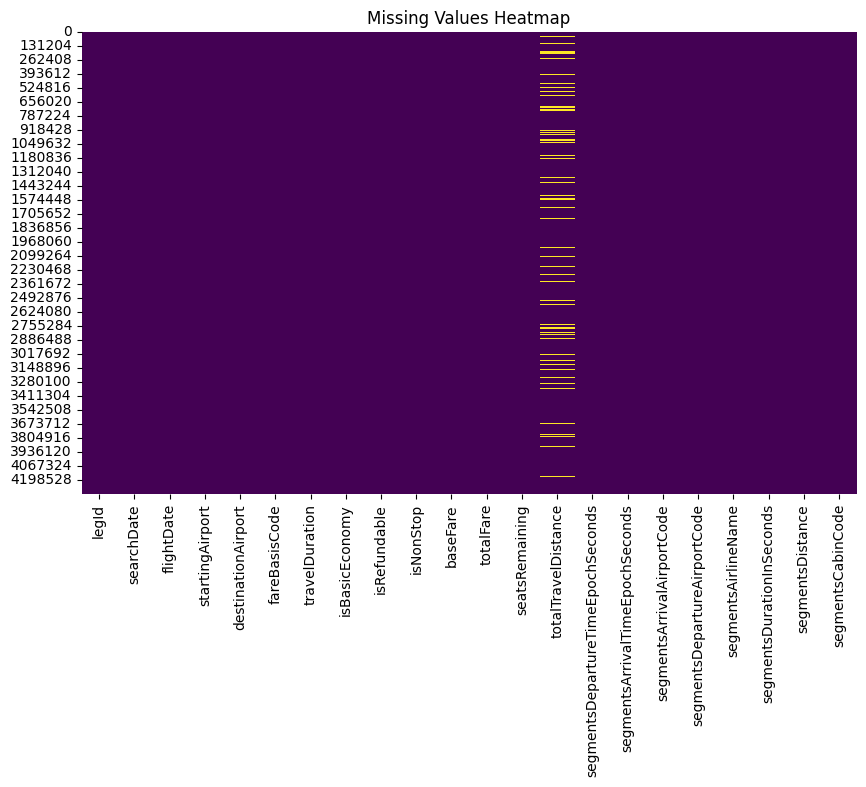

Number of duplicate rows: 0


In [15]:
#Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

#Drop null values
df = df.dropna().reset_index(drop=True)

## Initial Visualizations and Exploratory Data Analysis 

### Numerical Distribution Visualizations and Statistics (Univariate)


In [19]:
#The starting datatypes are not entirely representative of numerical/categorical features
#Numerical features are listed below for accurate summary statistics and analysis
numerical_features = ['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance', 'travelDurationMinutes']
summary_stats = df[numerical_features].describe().round(2)

print(summary_stats)

         baseFare   totalFare  seatsRemaining  totalTravelDistance  \
count  4329731.00  4329731.00      4329731.00           3873359.00   
mean       369.09      423.87            5.52              2195.85   
std        180.50      189.95            3.04               670.82   
min          1.00       19.59            0.00               338.00   
25%        256.74      305.61            3.00              1943.00   
50%        358.15      408.60            7.00              2438.00   
75%        467.91      527.21            7.00              2607.00   
max       6432.56     6934.10           10.00              3866.00   

       travelDurationMinutes  
count             4329731.00  
mean                  473.85  
std                   189.80  
min                    72.00  
25%                   340.00  
50%                   470.00  
75%                   578.00  
max                  1805.00  


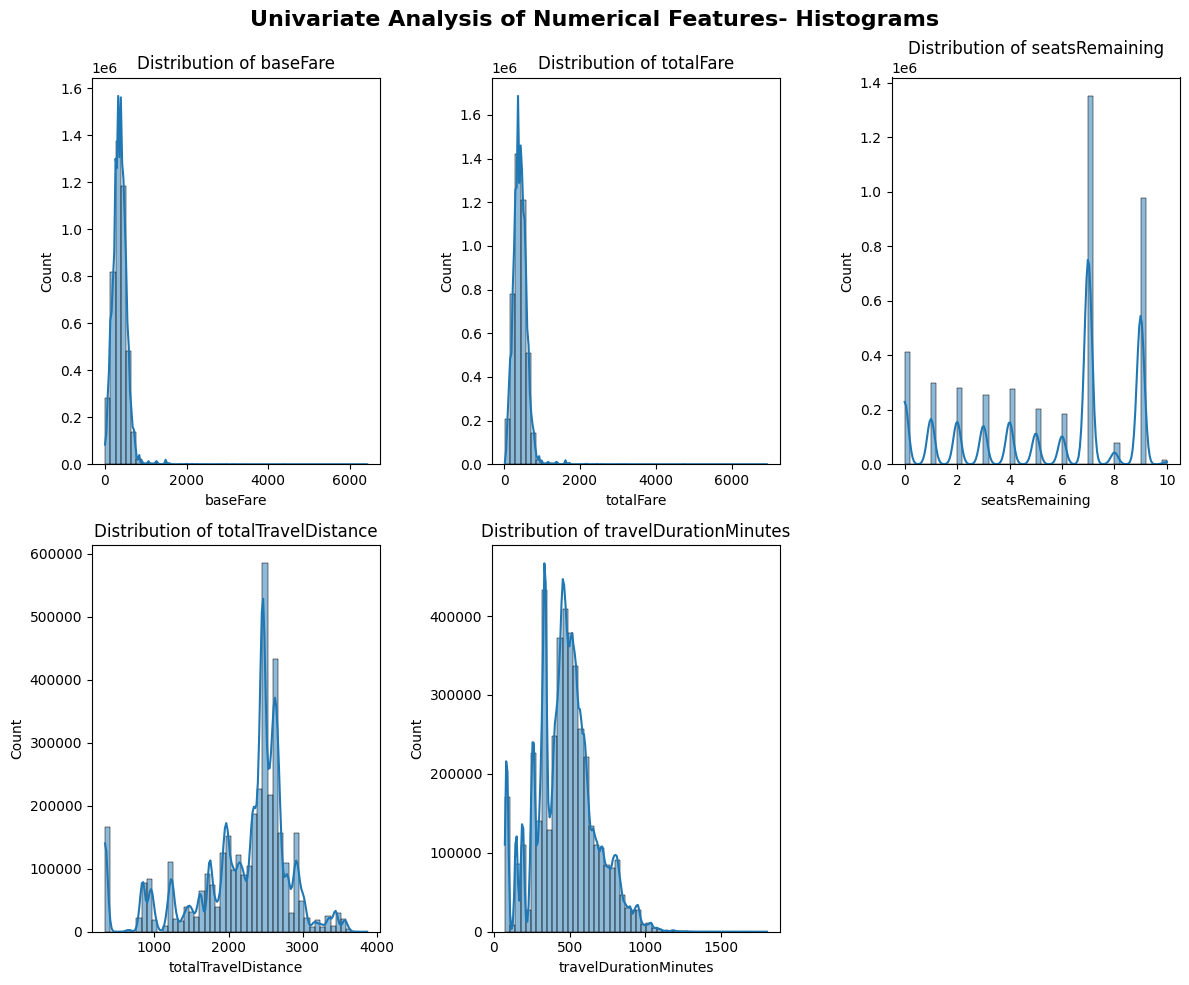

In [23]:
# Univariate Analysis - Histograms
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

for ax, feature in zip(axes.flat, numerical_features):
    sns.histplot(df[feature].dropna(), bins=50, kde=True, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")
    
if len(numerical_features) < len(axes):
    for j in range(len(numerical_features), len(axes)):
        fig.delaxes(axes[j])
    
fig.suptitle("Univariate Analysis of Numerical Features- Histograms", fontsize=16, fontweight='bold')

plt.tight_layout() 
plt.show()

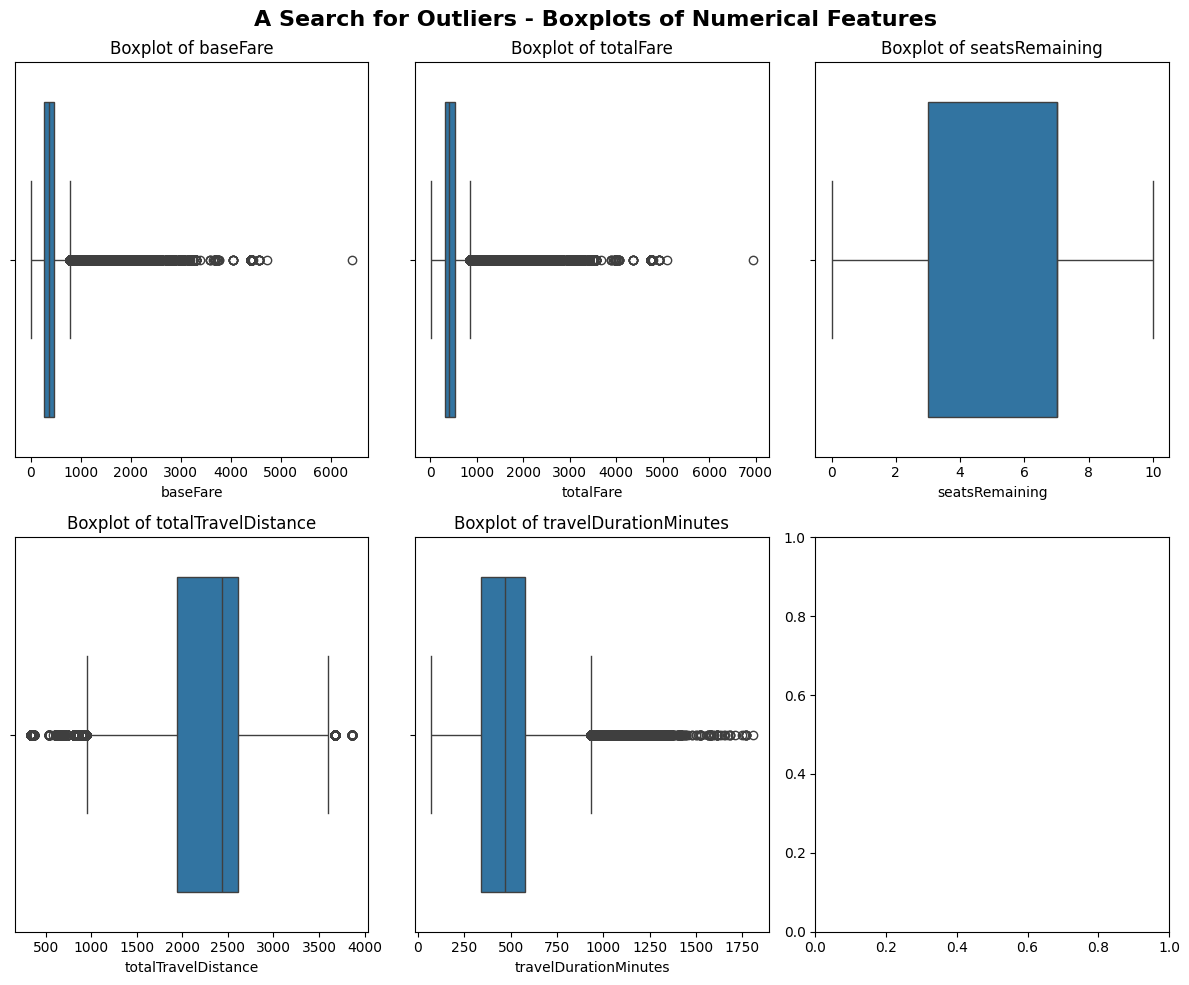

In [21]:
# Boxplots to check for outliers
fig, axes = plt.subplots(2, 3, figsize=(12, 10))  
axes = axes.flatten()  

for ax, feature in zip(axes, numerical_features):
    sns.boxplot(x=df[feature], ax=ax)
    ax.set_title(f"Boxplot of {feature}")
    
if len(numerical_features) < len(axes):
    for j in range(len(numerical_features), len(axes)):
        fig.delaxes(axes[j])

fig.suptitle("A Search for Outliers - Boxplots of Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

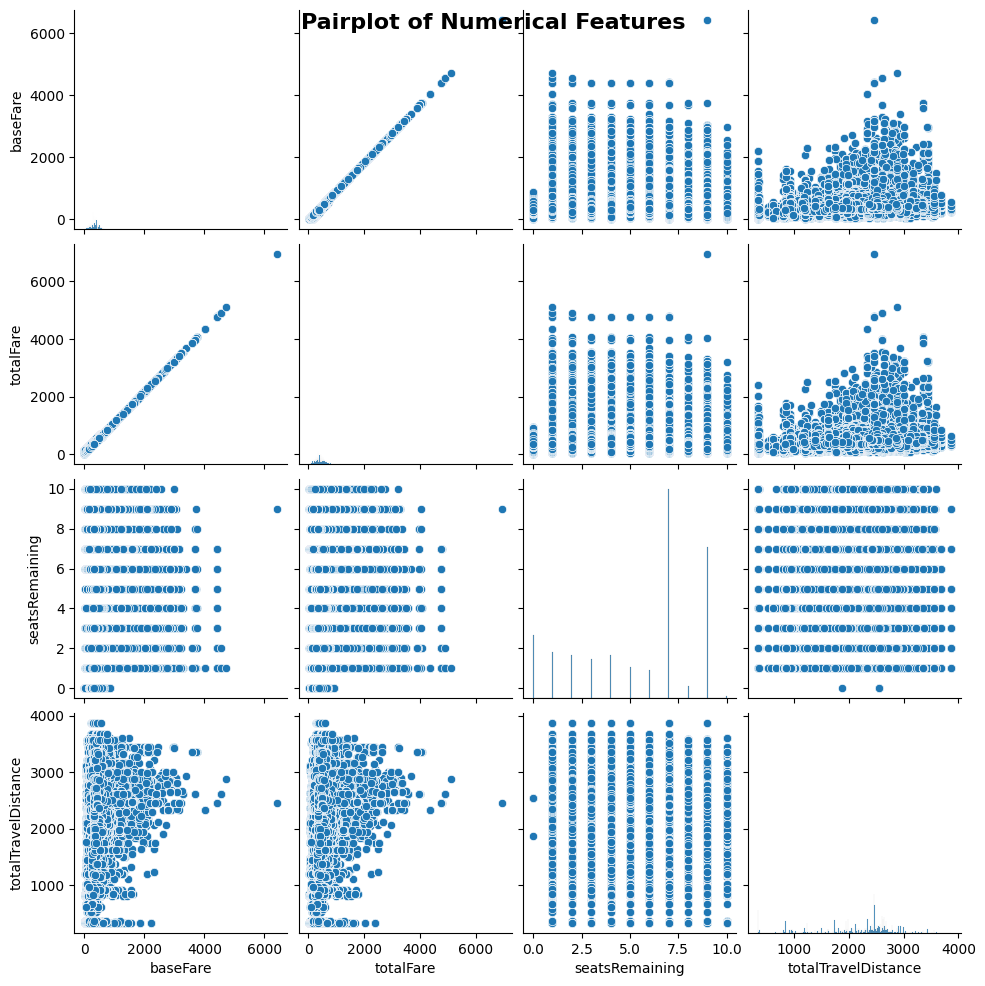

In [22]:
# Pairplot for relationships
pairplot = sns.pairplot(df[['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']])
pairplot.fig.suptitle("Pairplot of Numerical Features", fontsize=16, fontweight='bold')
plt.show()

### Numerical Comparison Visualizations (Multivariate)

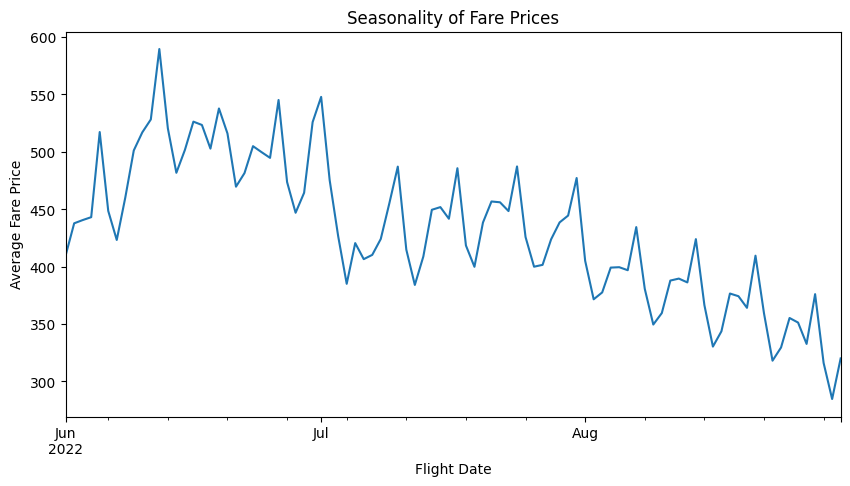

In [24]:
# Seasonality Analysis - Average Fare Over Time
fare_by_date = df.groupby('flightDate')['totalFare'].mean()
plt.figure(figsize=(10, 5))
fare_by_date.plot()
plt.xlabel("Flight Date")
plt.ylabel("Average Fare Price")
plt.title("Seasonality of Fare Prices")
plt.show()

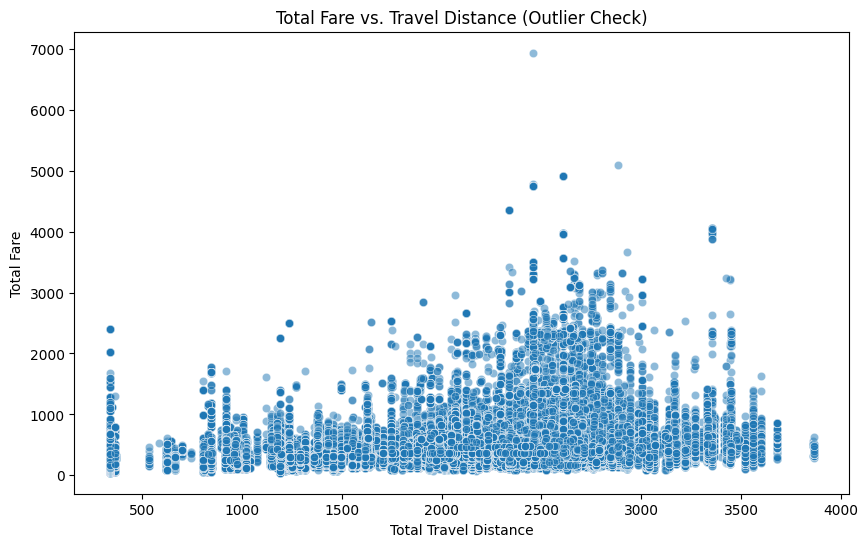

In [25]:
#Compare the relationship of travel distance and total fare
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['totalTravelDistance'], y=df['totalFare'], alpha=0.5)
plt.title("Total Fare vs. Travel Distance (Outlier Check)")
plt.xlabel("Total Travel Distance")
plt.ylabel("Total Fare")
plt.show()

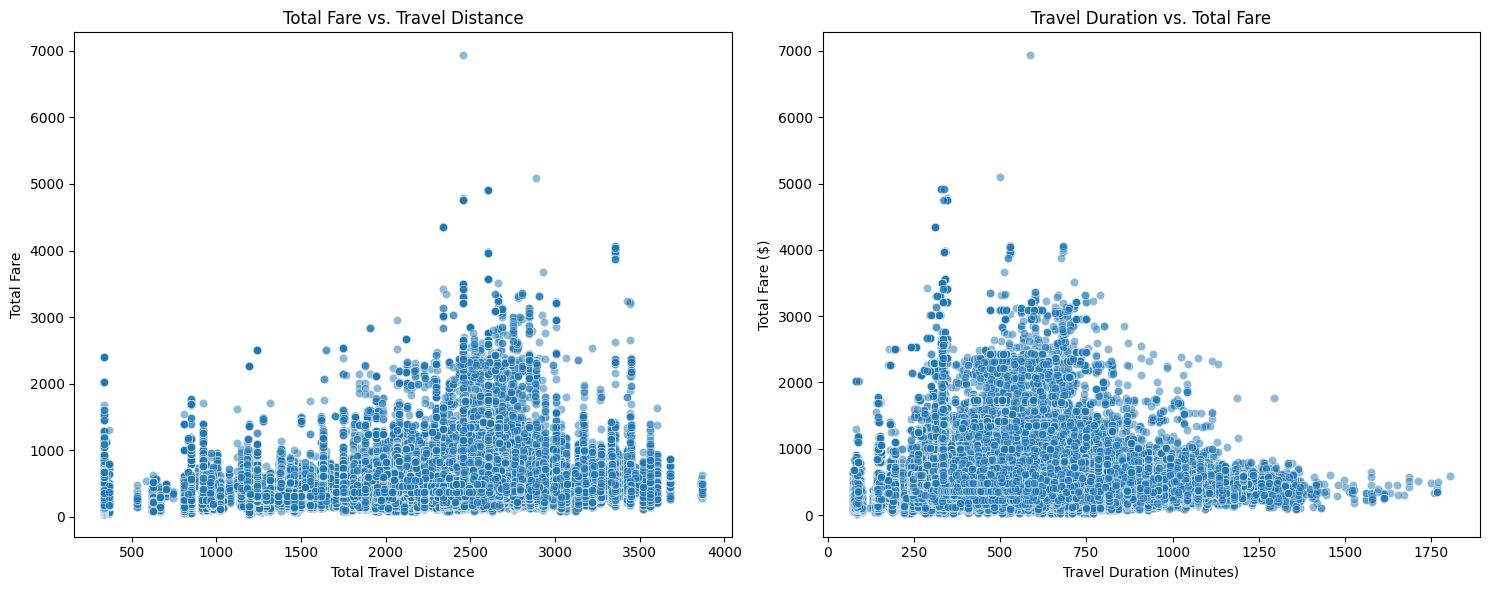

In [26]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot 1: Travel Distance vs. Total Fare
sns.scatterplot(x=df['totalTravelDistance'], y=df['totalFare'], alpha=0.5, ax=axes[0])
axes[0].set_title("Total Fare vs. Travel Distance")
axes[0].set_xlabel("Total Travel Distance")
axes[0].set_ylabel("Total Fare")

# Plot 2: Travel Duration vs. Total Fare
sns.scatterplot(x=df['travelDurationMinutes'], y=df['totalFare'], alpha=0.5, ax=axes[1])
axes[1].set_title("Travel Duration vs. Total Fare")
axes[1].set_xlabel("Travel Duration (Minutes)")
axes[1].set_ylabel("Total Fare ($)")

plt.tight_layout()
plt.show()

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/1634205217.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['seatsRemaining'], y=df['totalFare'], inner="quartile", scale="width", palette="coolwarm")
/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/1634205217.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x=df['seatsRemaining'], y=df['totalFare'], inner="quartile", scale="width", palette="coolwarm")


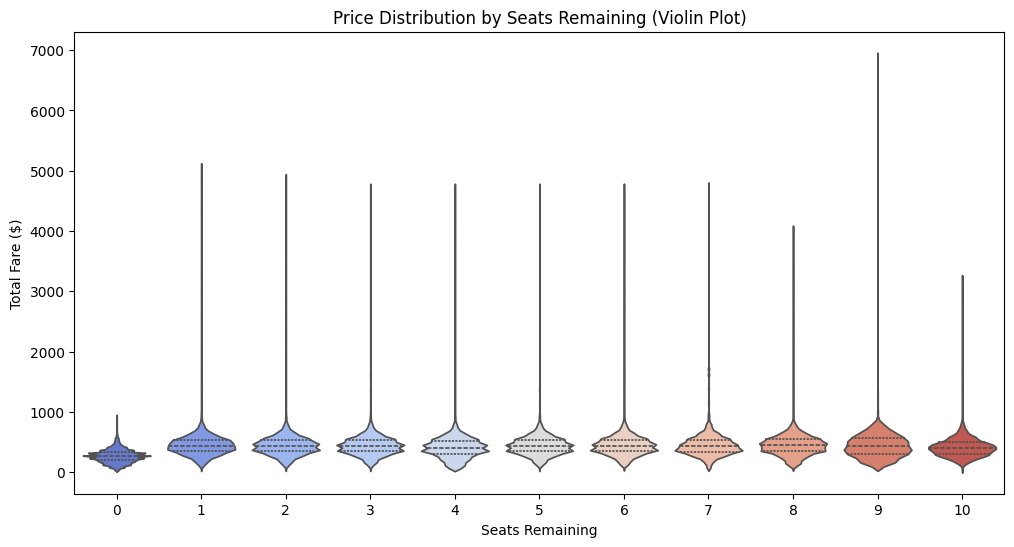

In [30]:
plt.figure(figsize=(12,6))
sns.violinplot(x=df['seatsRemaining'], y=df['totalFare'], inner="quartile", scale="width", palette="coolwarm")
plt.title("Price Distribution by Seats Remaining (Violin Plot)")
plt.xlabel("Seats Remaining")
plt.ylabel("Total Fare ($)")
plt.show()


In [28]:
# Compute correlation only for selected columns
correlation_matrix = df[numerical_features].corr()
print(correlation_matrix)


                       baseFare  totalFare  seatsRemaining  \
baseFare               1.000000   0.995827        0.195759   
totalFare              0.995827   1.000000        0.151604   
seatsRemaining         0.195759   0.151604        1.000000   
totalTravelDistance    0.407297   0.415230       -0.019324   
travelDurationMinutes  0.170281   0.211135       -0.190291   

                       totalTravelDistance  travelDurationMinutes  
baseFare                          0.407297               0.170281  
totalFare                         0.415230               0.211135  
seatsRemaining                   -0.019324              -0.190291  
totalTravelDistance               1.000000               0.629898  
travelDurationMinutes             0.629898               1.000000  


### Categorical Visualizations and Statistics (Univariate)

In [36]:
#Identifying categorical features
categorical_features = ['isBasicEconomy', 'isNonStop', 'isRefundable', 'destinationAirport','fareBasisCode']

In [37]:
#Check for number of unique categories
for feature in categorical_features:
    print(f"{feature}: {df[feature].nunique()} unique values")

isBasicEconomy: 2 unique values
isNonStop: 2 unique values
isRefundable: 2 unique values
destinationAirport: 15 unique values
fareBasisCode: 4828 unique values


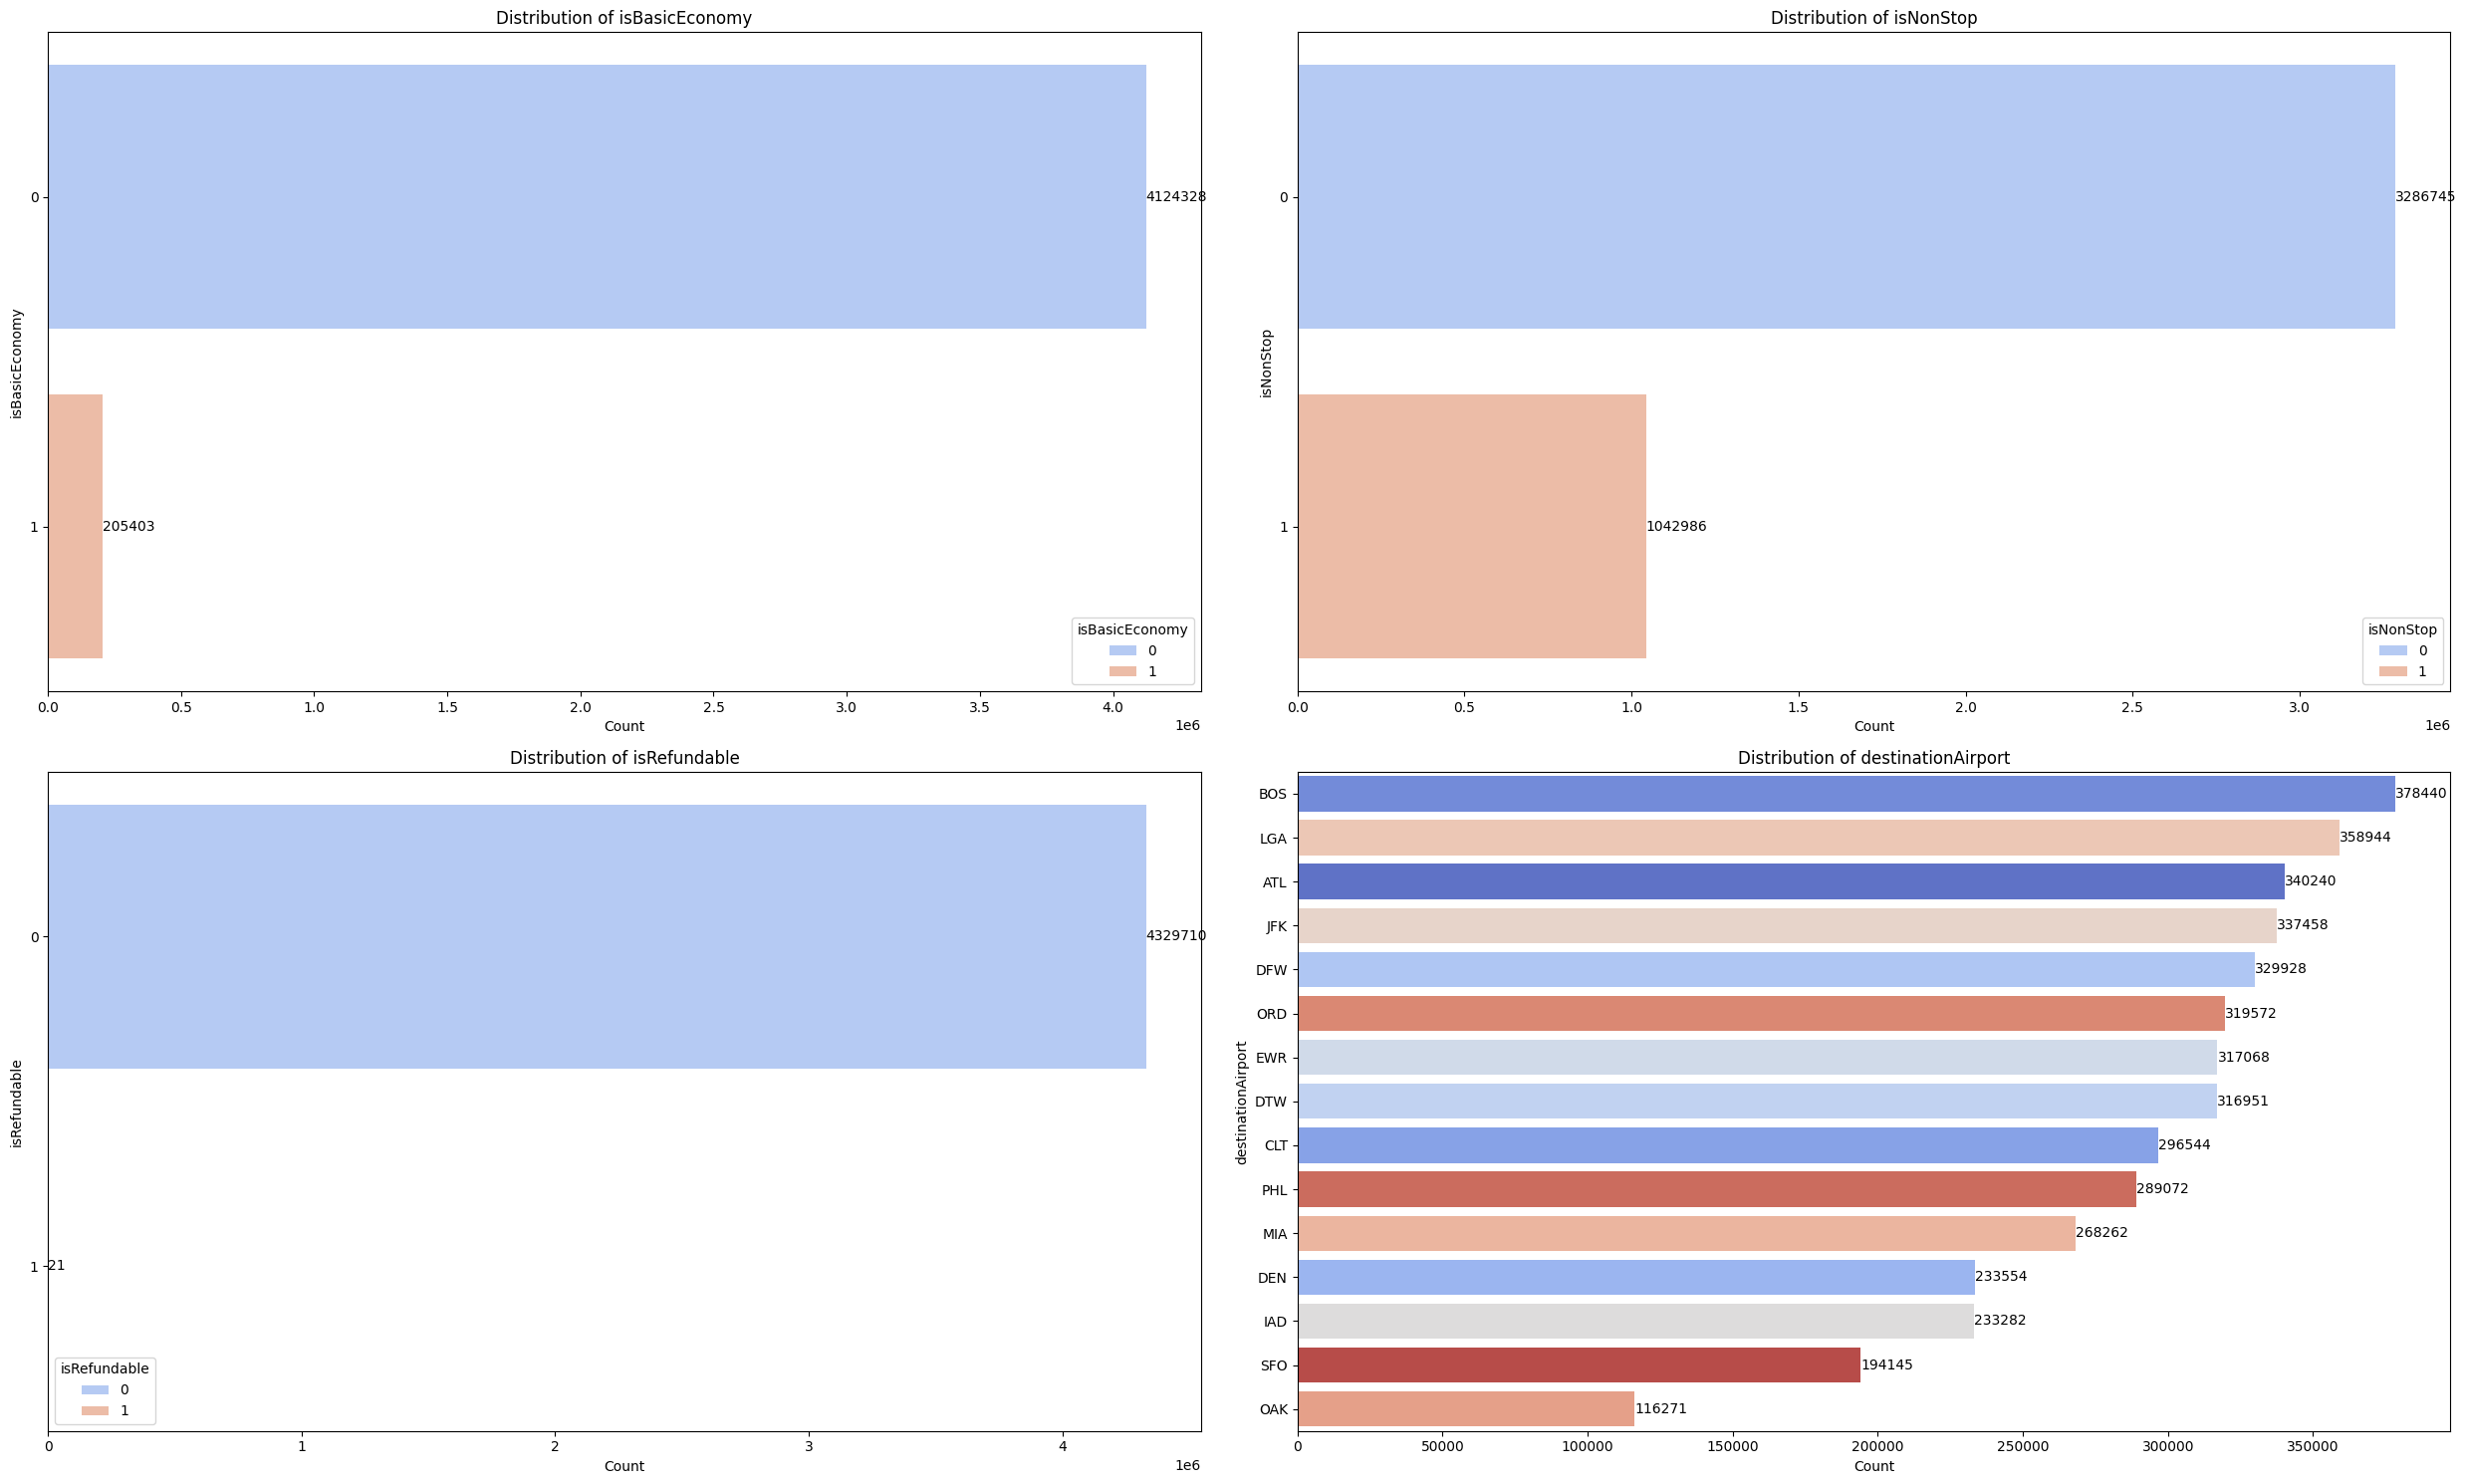


Value counts for isBasicEconomy:
isBasicEconomy
0    4124328
1     205403
Name: count, dtype: int64

Value counts for isNonStop:
isNonStop
0    3286745
1    1042986
Name: count, dtype: int64

Value counts for isRefundable:
isRefundable
0    4329710
1         21
Name: count, dtype: int64

Value counts for destinationAirport:
destinationAirport
BOS    378440
LGA    358944
ATL    340240
JFK    337458
DFW    329928
ORD    319572
EWR    317068
DTW    316951
CLT    296544
PHL    289072
MIA    268262
DEN    233554
IAD    233282
SFO    194145
OAK    116271
Name: count, dtype: int64


In [45]:
categorical_features_refined = ['isBasicEconomy', 'isNonStop', 'isRefundable', 'destinationAirport']

fig, axes = plt.subplots(2, 2, figsize=(25, 15)) 
axes = axes.flatten()

for i, col in enumerate(categorical_features_refined):
    ax = sns.countplot(y=df[col], ax=axes[i], order=df[col].value_counts().index, hue=df[col], palette="coolwarm")

    # Add count labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%d') 

    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("Count")
    
plt.tight_layout()
plt.show()


# Print counts of occurrences for categorical variables
for feature in categorical_features_refined:
    print(f"\nValue counts for {feature}:")
    print(df[feature].value_counts())


### Categorical Visualizations and Relationships (Multivariate)

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/1128742415.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm")


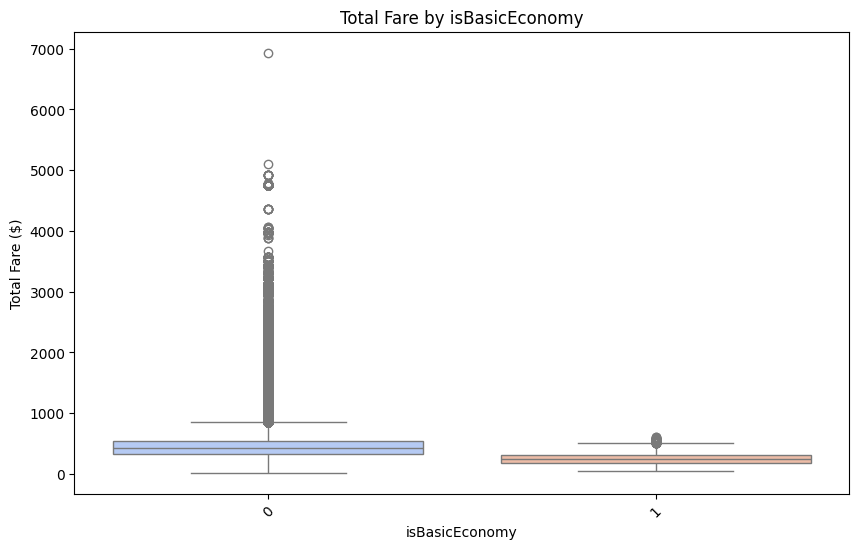

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/1128742415.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm")


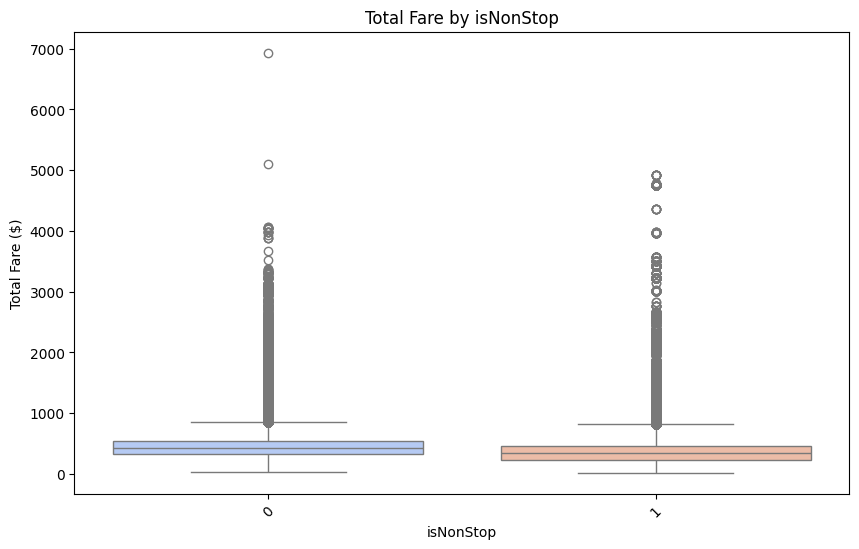

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/1128742415.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm")


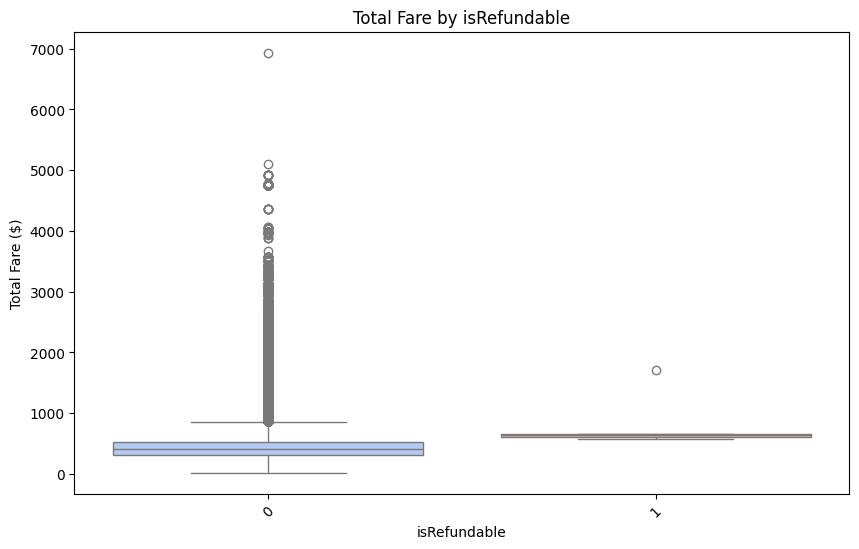

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/1128742415.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm")


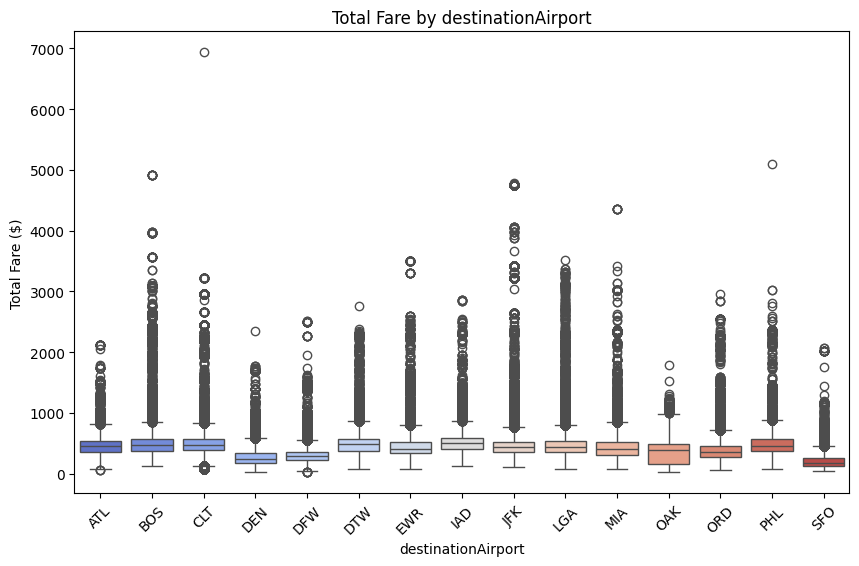

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/1128742415.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm")


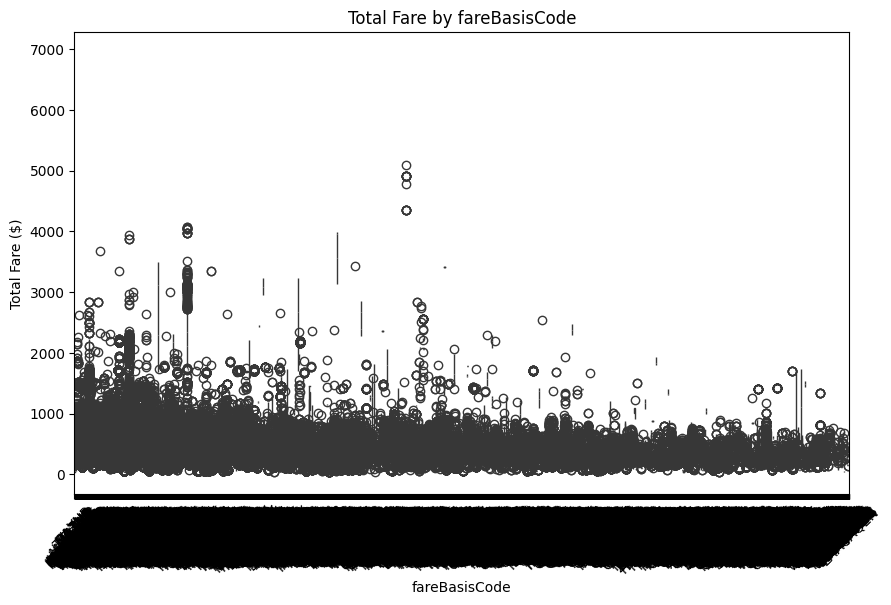

In [ ]:
pd.crosstab(df['destinationAirport'], df['isNonStop'])

plt.figure(figsize=(10,6))
sns.heatmap(pd.crosstab(df['destinationAirport'], df['isNonStop']), annot=True, cmap="coolwarm")
plt.title("Non-Stop Flights by Destination Airport")
plt.xlabel("Non-Stop Flight?")
plt.ylabel("Destination Airport")
plt.show()

In [44]:
#Understand interactions between categories. Good for feature engineering purposes

#Are certain Fare Classes more likely to be refundable?
pd.crosstab(df['fareBasisCode'], df['isRefundable'])
pd.crosstab(df['destinationAirport'], df['isNonStop'])


isNonStop,0,1
destinationAirport,,
ATL,260598,79642
BOS,291335,87105
CLT,260618,35926
DEN,144320,89234
DFW,214662,115266
DTW,279148,37803
EWR,236206,80862
IAD,207086,26196
JFK,179502,157956


### Categorical and Numerical comparisons 

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/2058832972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm")


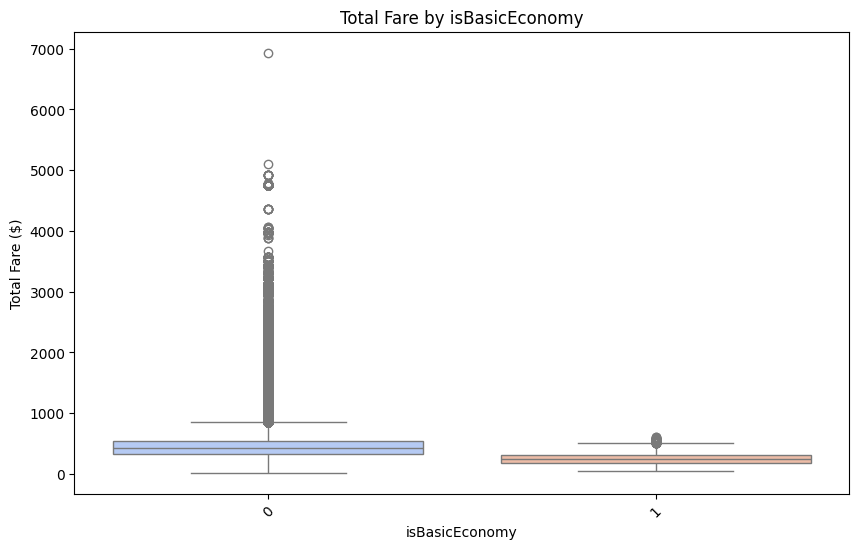

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/2058832972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm")


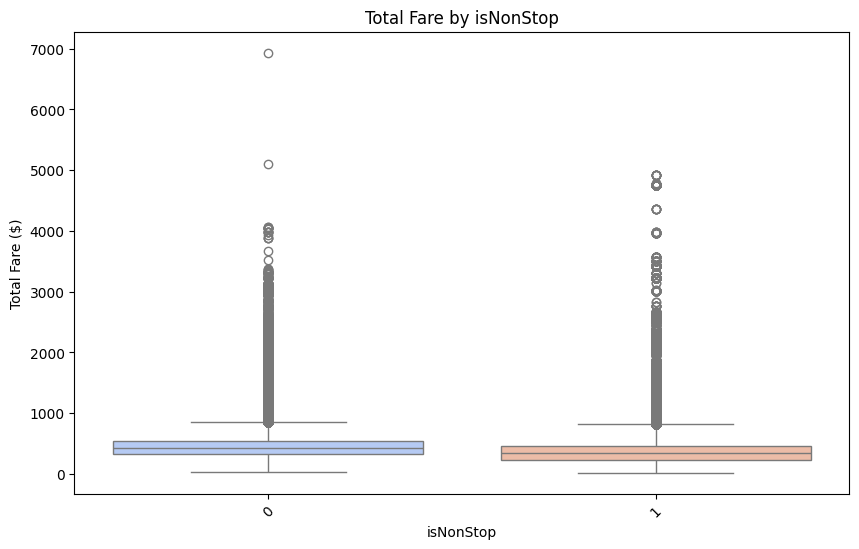

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/2058832972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm")


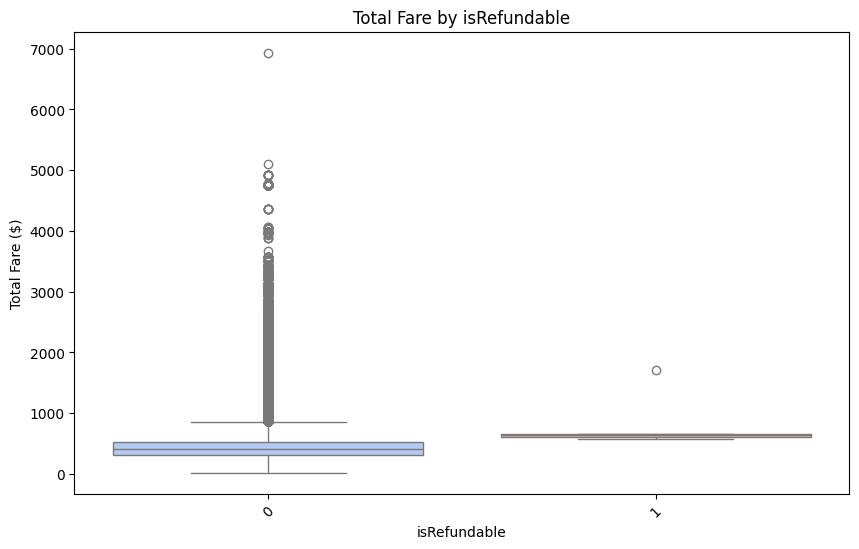

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/2058832972.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm")


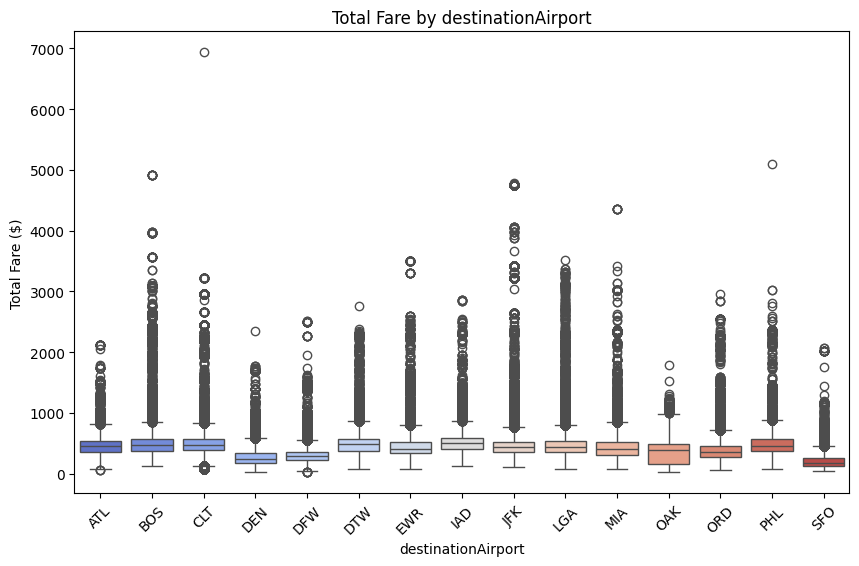

In [46]:
#How do categorical features affect price?
for col in categorical_features_refined:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=df[col], y=df['totalFare'], palette="coolwarm")
    plt.title(f"Total Fare by {col}")
    plt.xlabel(col)
    plt.ylabel("Total Fare ($)")
    plt.xticks(rotation=45)
    plt.show()

/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_20138/676969412.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['destinationAirport'], y=df['travelDurationMinutes'], palette="coolwarm")


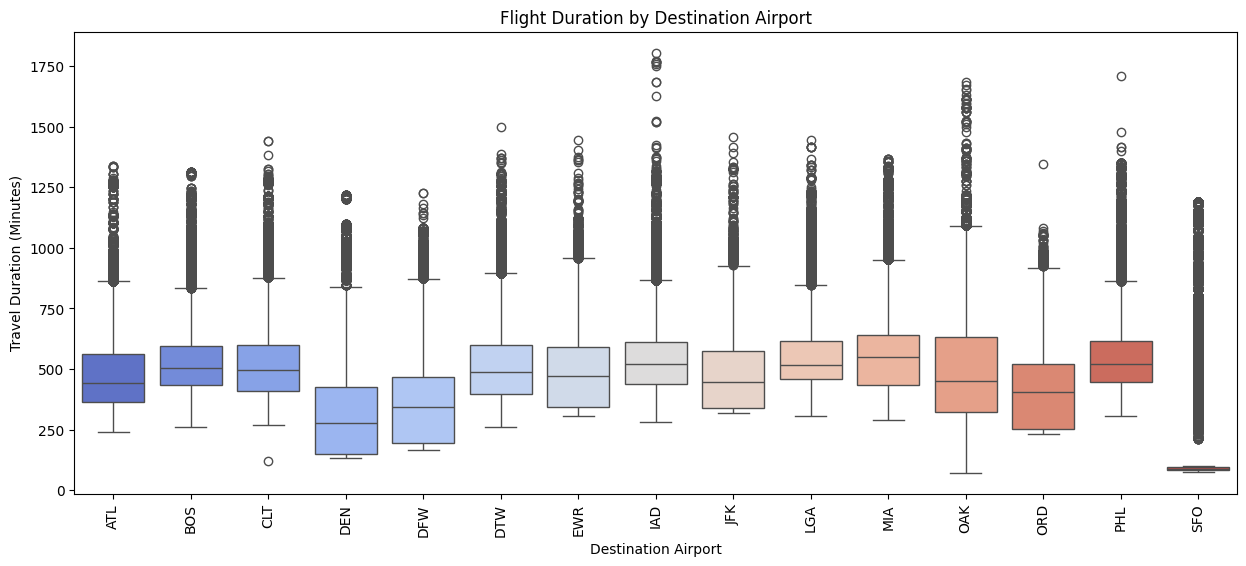

In [47]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['destinationAirport'], y=df['travelDurationMinutes'], palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Flight Duration by Destination Airport")
plt.xlabel("Destination Airport")
plt.ylabel("Travel Duration (Minutes)")
plt.show()


## Feature Engineering 

In [16]:
#Time Related Features
df['daysToDeparture'] = (df['flightDate'] - df['searchDate']).dt.days

df['flightMonth'] = df['flightDate'].dt.month
df['flightDay'] = df['flightDate'].dt.dayofweek

df['searchMonth'] = df['searchDate'].dt.month
df['searchDay'] = df['searchDate'].dt.dayofweek

#Calculate the price per mile 
df['pricePerMile'] = df['totalFare'] / df['totalTravelDistance']

In [ ]:
# Distribution of days to departure
sns.histplot(df['daysToDeparture'], bins=30, kde=True)
plt.title("Distribution of Days to Departure")
plt.show()

In [ ]:
# Group by days to departure to analyze average fare trends
avg_fare_trend = df.groupby('daysToDeparture')['totalFare'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_fare_trend, x='daysToDeparture', y='totalFare')
plt.title("Average Fare by Days to Departure")
plt.xlabel("Days to Departure")
plt.ylabel("Average Fare")
plt.show()

In [17]:
us_holidays = holidays.US()
df['isHoliday'] = df['flightDate'].apply(lambda date: 1 if date in us_holidays else 0)

# Create pre-holiday and post-holiday indicators
df['preHolidayFlight'] = df['flightDate'].apply(lambda date: 1 if any((date - pd.Timedelta(days=i)) in us_holidays for i in range(1, 6)) else 0)
df['postHolidayFlight'] = df['flightDate'].apply(lambda date: 1 if any((date + pd.Timedelta(days=i)) in us_holidays for i in range(1, 6)) else 0)

# Compute daysUntilHoliday
def get_daysUntilHolidayiday(date):
    holidays_list = sorted([pd.Timestamp(holiday) for holiday in us_holidays.keys()])
    
    # Find the nearest holiday before and after the flight date
    previous_holiday = max([h for h in holidays_list if h <= date], default=None)
    next_holiday = min([h for h in holidays_list if h >= date], default=None)
    
    # Calculate the days until the nearest holiday
    daysBeforeHoliday = (date - previous_holiday).days if previous_holiday else float('inf')
    daysAfterHoliday = (next_holiday - date).days if next_holiday else float('inf')

    # Return the smallest absolute difference (positive for future, negative for past holidays)
    if abs(daysBeforeHoliday) < abs(daysAfterHoliday):
        return -daysBeforeHoliday  # Negative if the closest holiday was in the past
    return daysAfterHoliday  # Positive if the closest holiday is in the future

# Apply the function to compute daysUntilHoliday
df['daysUntilHoliday'] = df['flightDate'].apply(get_daysUntilHolidayiday)

### Segment Feature Engineering 


In [18]:
df['numberLegs'] = df['segmentsDepartureTimeEpochSeconds'].str.count(r'\|\|') + 1
max_segments = df['numberLegs'].max()

print(f"Maximum number of segments in any row: {max_segments}")



Maximum number of segments in any row: 4


In [ ]:
# Relationship between number of segments and totalFare
sns.boxplot(x='numberLegs', y='totalFare', data=df)
plt.title("Total Fare by Number of Flight Legs")
plt.show()

In [ ]:
#Visualizing the distribution of legs of flights
plt.figure(figsize=(10,6))
sns.histplot(df['numberLegs'], bins=10, kde=False, color='skyblue')
plt.title("Distribution of Number of Legs")
plt.xlabel("Number of Legs")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Scatterplot of totalFare vs. daysToDeparture
sns.scatterplot(x=df['daysToDeparture'], y=df['totalFare'], hue=df['numberLegs'])
plt.title("Total Fare vs. Days to Departure (Colored by Segments)")
plt.show()

In [19]:
# Split departure and arrivals into separate columns
df[['dep_1', 'dep_2', 'dep_3', 'dep_4']] = df['segmentsDepartureTimeEpochSeconds'].str.split(r'\|\|', expand=True)
df[['arr_1', 'arr_2', 'arr_3', 'arr_4']] = df['segmentsArrivalTimeEpochSeconds'].str.split(r'\|\|', expand=True)

# Convert epoch times to datetime
for col in ['dep_1', 'dep_2', 'dep_3', 'dep_4', 'arr_1', 'arr_2', 'arr_3', 'arr_4']:
    df[col] = pd.to_datetime(df[col].astype(float), unit='s', errors='coerce')
    

In [20]:
#Find hour of departure and arrival. Inspired by literature
df["departureHour"] = df["dep_1"].dt.hour
df["departureMinute"] = df["dep_1"].dt.minute

# Get the last valid arrival time by backfilling from right to left
df["final_arrival"] = df[["arr_4", "arr_3", "arr_2", "arr_1"]].bfill(axis=1).iloc[:, 0]

# Extract hour and minute from the final arrival time
df["arrivalHour"] = df["final_arrival"].dt.hour
df["arrivalMinute"] = df["final_arrival"].dt.minute

# Create a column to check if final arrival is on the next day and convert to 0/1
df["arrivalNextDay"] = (df["final_arrival"].dt.date > df["dep_1"].dt.date).astype(int)


# Drop the intermediate column if not needed
df.drop(columns=["final_arrival"], inplace=True)



In [21]:
# Calculate layover times for each segment
def calculate_layover(dep_col, arr_col, next_dep_col):
    if pd.notna(dep_col) and pd.notna(arr_col):
        return (next_dep_col - arr_col).total_seconds() / 3600 if pd.notna(next_dep_col) else 0
    return 0

# Calculate layover times for each segment
df['layover_1'] = df.apply(lambda row: calculate_layover(row['dep_1'], row['arr_1'], row['dep_2']), axis=1)
df['layover_2'] = df.apply(lambda row: calculate_layover(row['dep_2'], row['arr_2'], row['dep_3']), axis=1)
df['layover_3'] = df.apply(lambda row: calculate_layover(row['dep_3'], row['arr_3'], row['dep_4']), axis=1)

# Sum layover times, handling NaNs
df['totalLayoverTime'] = df[['layover_1', 'layover_2', 'layover_3']].sum(axis=1, skipna=True)




In [22]:
# Calculate the total flight duration, excluding layovers
def calculate_flight_duration(row):
    total_duration = 0
    num_segments = row['numberLegs']
    
    # Ensure there are valid departure and arrival times to compute the duration
    if num_segments >= 1 and pd.notna(row['dep_1']) and pd.notna(row[f'arr_{num_segments}']):
        # Total time between first departure and last arrival
        total_duration = (row[f'arr_{num_segments}'] - row['dep_1']).total_seconds() / 3600
    
    # Subtract layover times to get only time spent flying
    total_duration -= row['totalLayoverTime']
    
    return total_duration

# Apply the function to calculate total flight duration
df['totalAirtime'] = df.apply(calculate_flight_duration, axis=1)

In [63]:
'''
# Calculate segment durations for each leg
def calculate_segment_duration(dep_col, arr_col):
    """Calculate the duration of a segment between departure and arrival times."""
    if pd.notna(dep_col) and pd.notna(arr_col):
        return (arr_col - dep_col).total_seconds() / 3600  # Duration in hours
    return 0

# Apply the function to calculate segment durations for each leg
df['segment_1_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_1'], row['arr_1']), axis=1)
df['segment_2_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_2'], row['arr_2']), axis=1)
df['segment_3_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_3'], row['arr_3']), axis=1)
df['segment_4_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_4'], row['arr_4']), axis=1)

# Update max_segment_duration by finding the maximum duration of the available segments
df['maxSegmentDuration'] = df[['segment_1_duration', 'segment_2_duration', 'segment_3_duration', 'segment_4_duration']].max(axis=1, skipna=True)

# Calculate average segment duration (excluding zero durations)
def calculate_avg_segment_duration(row):
    """Calculate average segment duration excluding zero values."""
    segment_durations = [
        row['segment_1_duration'],
        row['segment_2_duration'],
        row['segment_3_duration'],
        row['segment_4_duration']
    ]
    
    # Filter out zero durations
    non_zero_durations = [duration for duration in segment_durations if duration > 0]
    
    if non_zero_durations:  # Check if there are non-zero durations
        return sum(non_zero_durations) / len(non_zero_durations)
    else:
        return 0  # Return 0 if no valid segment durations are found

# Apply the function to calculate the average segment duration
df['averageSegmentDuration'] = df.apply(calculate_avg_segment_duration, axis=1)
'''

'\n# Calculate segment durations for each leg\ndef calculate_segment_duration(dep_col, arr_col):\n    """Calculate the duration of a segment between departure and arrival times."""\n    if pd.notna(dep_col) and pd.notna(arr_col):\n        return (arr_col - dep_col).total_seconds() / 3600  # Duration in hours\n    return 0\n\n# Apply the function to calculate segment durations for each leg\ndf[\'segment_1_duration\'] = df.apply(lambda row: calculate_segment_duration(row[\'dep_1\'], row[\'arr_1\']), axis=1)\ndf[\'segment_2_duration\'] = df.apply(lambda row: calculate_segment_duration(row[\'dep_2\'], row[\'arr_2\']), axis=1)\ndf[\'segment_3_duration\'] = df.apply(lambda row: calculate_segment_duration(row[\'dep_3\'], row[\'arr_3\']), axis=1)\ndf[\'segment_4_duration\'] = df.apply(lambda row: calculate_segment_duration(row[\'dep_4\'], row[\'arr_4\']), axis=1)\n\n# Update max_segment_duration by finding the maximum duration of the available segments\ndf[\'maxSegmentDuration\'] = df[[\'segme

In [26]:
# Extract the first layover airport code (if it exists)
# Assuming the 'segmentsArrivalAirportCode' column contains the layover airport codes, separated by '||'
df['segmentsArrivalAirportCode'] = df['segmentsArrivalAirportCode'].fillna('')
df['firstLayoverAirport'] = df['segmentsArrivalAirportCode'].apply(
    lambda x: x.split('||')[0] if isinstance(x, str) and '||' in x else x
)
print(df['firstLayoverAirport'].value_counts())


firstLayoverAirport
DFW    393429
DEN    332506
ORD    306334
SFO    301204
ATL    271101
        ...  
EUG         6
MFR         5
BWI         3
COS         2
OMA         1
Name: count, Length: 67, dtype: int64


In [27]:
#Find the primary airline over all the segments of a flight 
df['mainAirline'] = df['segmentsAirlineName'].str.split(r'\|\|').apply(lambda x: max(set(x), key=x.count) if isinstance(x, list) else x)


In [28]:
# Use raw string to avoid escape sequence warning
df['cabin_classes'] = df['segmentsCabinCode'].str.split(r'\|\|')

# Remove any unnecessary characters (like leading/trailing spaces or empty strings)
df['cabin_classes'] = df['cabin_classes'].apply(lambda x: [i.strip() for i in x if i.strip() != ''])

# Verify the first few rows to ensure proper splitting
print(df['cabin_classes'].head())

# Check if all cabin classes are the same for each flight
df['same_cabin_type'] = df['cabin_classes'].apply(lambda x: len(set(x)) == 1)

# Count flights with same vs. different cabin types
same_cabin_count = df['same_cabin_type'].sum()
different_cabin_count = len(df) - same_cabin_count

print(f"Number of flights with the same cabin type: {same_cabin_count}")
print(f"Number of flights with different cabin types: {different_cabin_count}")

# Split based on '||' and find unique cabin classes
df['cabin_classes'] = df['segmentsCabinCode'].str.split(r'\|\|')

# Flatten the list and get the unique cabin classes
unique_cabin_classes = df['cabin_classes'].explode().unique()

# Display the unique cabin classes
print("Unique cabin classes:", unique_cabin_classes)

0    [coach, coach]
1    [coach, coach]
2    [coach, coach]
3    [coach, coach]
4    [coach, coach]
Name: cabin_classes, dtype: object
Number of flights with the same cabin type: 3865627
Number of flights with different cabin types: 7732
Unique cabin classes: ['coach' 'premium coach' 'first' 'business']


In [33]:
# Split SegmentsCabinCode into individual cabin classes
df['cabin_classes'] = df['segmentsCabinCode'].str.split(r'\|\|')

# Convert cabin classes into unique combinations of classes
df['cabinClassesCombination'] = df['cabin_classes'].map(lambda x: '|'.join(sorted(set(x))) if isinstance(x, list) else '')

# Define the ordered combinations
raw_combinations = [
    'coach', 'coach|premium coach', 'premium coach', 'coach|business',
    'premium coach|business', 'business', 'coach|first', 'premium coach|first',
    'first|business', 'first'
]

# **Ensure all predefined combinations are also sorted**
ordered_combinations = ['|'.join(sorted(comb.split('|'))) for comb in raw_combinations]

# Make a fast lookup dictionary for mapping
combination_mapping = {comb: idx for idx, comb in enumerate(ordered_combinations)}

# Map the sorted combinations 
df['cabin_classes_ordinal'] = df['cabinClassesCombination'].map(combination_mapping)

# Check for missing mappings
missing_combinations = df.loc[df['cabin_classes_ordinal'].isna(), 'cabinClassesCombination'].unique()
print("Missing cabin class combinations:", missing_combinations)

Missing cabin class combinations: []


### Lag Features
Lag features represent the values of a variable at previous time points


There are a high occurrence of legIds that only appear once, meaning the use of legId for grouping of lag features is not ideal, it can lead to excessive granularity and not be as useful of a feature. Instead, we can group by starting and destination airports. 

In [34]:
# Count occurrences of each legId
legid_counts = df['legId'].value_counts()
print(legid_counts.head(10))

#Statistics about legId occurrences
print("Unique legIds:", legid_counts.count())
print("Max occurrences of a legId:", legid_counts.max())
print("Min occurrences of a legId:", legid_counts.min())
print("Average occurrences per legId:", legid_counts.mean())

# Check how many legIds occur only once
single_occurrences = (legid_counts == 1).sum()
sixty_occurrences = (legid_counts == 60).sum()
print("Number of legIds that appear only once:", single_occurrences)
print("Number of legIds that appear 60 times:", sixty_occurrences)

legId
1eb0e588bd01f1c3186ac18d25170f9a    60
46e498200858215044c2785a6ed65b0d    60
cea59416664b64aa0f2360782afe9704    60
e11157f8f107f9b7a6cb169a18b7edd3    60
52fdb28b76a8142e78171ec3beb5a68a    60
4ff68b29bd7078702fcb1e1151f67e8e    60
5a6a8040a10d321dda63bd4908d04769    60
4cbcddb206b6ca0655c10defd6f0c91f    60
f93cecbc9b551a3b94cc34c0c7fcc51c    60
ca006e2d85e776e2d51af3ad009e7a83    60
Name: count, dtype: int64
Unique legIds: 275531
Max occurrences of a legId: 60
Min occurrences of a legId: 1
Average occurrences per legId: 14.05779748921174
Number of legIds that appear only once: 52951
Number of legIds that appear 60 times: 886


In [35]:
# Sort by route and search date
df = df.sort_values(by=['destinationAirport', 'searchDate'])

# Create lag features for 1-day, 7-day, and 30-day periods
df['fareLag_1'] = df.groupby(['destinationAirport'])['totalFare'].shift(1)
df['fareLag_7'] = df.groupby(['destinationAirport'])['totalFare'].shift(7)
df['fareLag_30'] = df.groupby(['destinationAirport'])['totalFare'].shift(30)

# Create rolling average features
df['fare_rolling_avg_7'] = df.groupby(['destinationAirport'])['totalFare'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['fare_rolling_avg_30'] = df.groupby(['destinationAirport'])['totalFare'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Fill missing values in lag features using rolling averages
df['fareLag_1'] = df['fareLag_1'].fillna(df['fare_rolling_avg_30'])  # Prefer 30-day average
df['fareLag_1'] = df['fareLag_1'].fillna(df['fare_rolling_avg_7'])   # If still NaN, use 7-day avg
df['fareLag_1'] = df['fareLag_1'].fillna(method='ffill')             # Finally, use forward fill

# Inspect the results
print(df[['destinationAirport', 'searchDate', 'totalFare', 'fareLag_1', 'fare_rolling_avg_7', 'fare_rolling_avg_30']].head(20))


/var/folders/0p/79qfdxv10wbds7v0r2qmyh900000gn/T/ipykernel_1924/1650217623.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['fareLag_1'] = df['fareLag_1'].fillna(method='ffill')             # Finally, use forward fill


   destinationAirport searchDate  totalFare  fareLag_1  fare_rolling_avg_7  \
0                 ATL 2022-04-17     193.99     193.99          193.990000   
1                 ATL 2022-04-17     248.61     193.99          221.300000   
2                 ATL 2022-04-17     277.60     248.61          240.066667   
3                 ATL 2022-04-17     277.60     277.60          249.450000   
4                 ATL 2022-04-17     277.60     277.60          255.080000   
5                 ATL 2022-04-17     277.60     277.60          258.833333   
6                 ATL 2022-04-17     323.60     277.60          268.085714   
7                 ATL 2022-04-17     323.60     323.60          286.601429   
8                 ATL 2022-04-17     323.60     323.60          297.314286   
9                 ATL 2022-04-17     323.60     323.60          303.885714   
10                ATL 2022-04-17     323.60     323.60          310.457143   
11                ATL 2022-04-17     327.60     323.60          

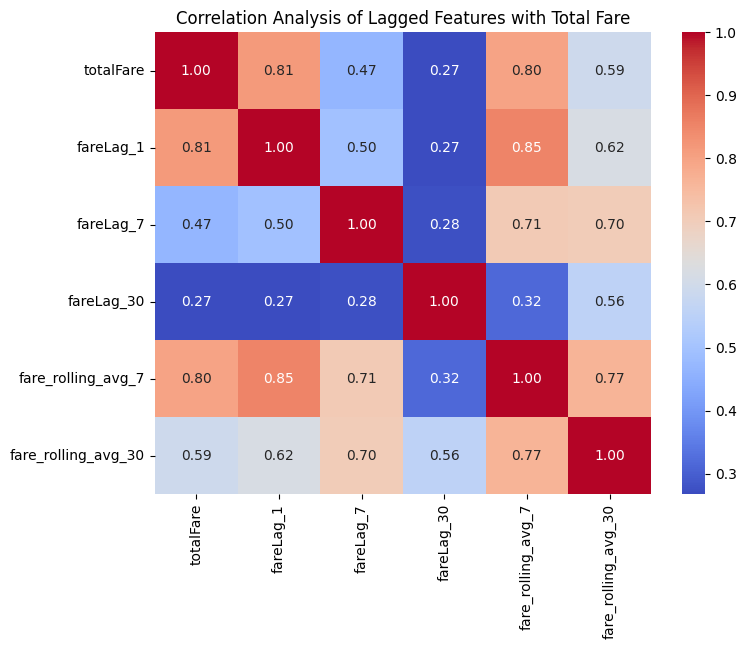

In [37]:
#Check correlation between lag features and totalFare
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Analysis of Lagged Features with Total Fare")
plt.show()


The most correlated features are fare_lag_1, fare_rolling_avg_7, and fare_rolling_avg_30. However, fare_lag_1 and fare_rolling_avg_7 have high correlation with each other, which may introduce redundancy into the model. One may need to be dropped if multicollinearity affects model 

In [72]:
#Drop the lag features that do not have a high correlation with totalFare
df = df.drop(['fare_rolling_avg_7', 'fareLag_7', 'fareLag_30'], axis=1)

#All elements of searchDate have been extracted, drop searchDate
df = df.drop(columns=['searchDate'], axis=1)

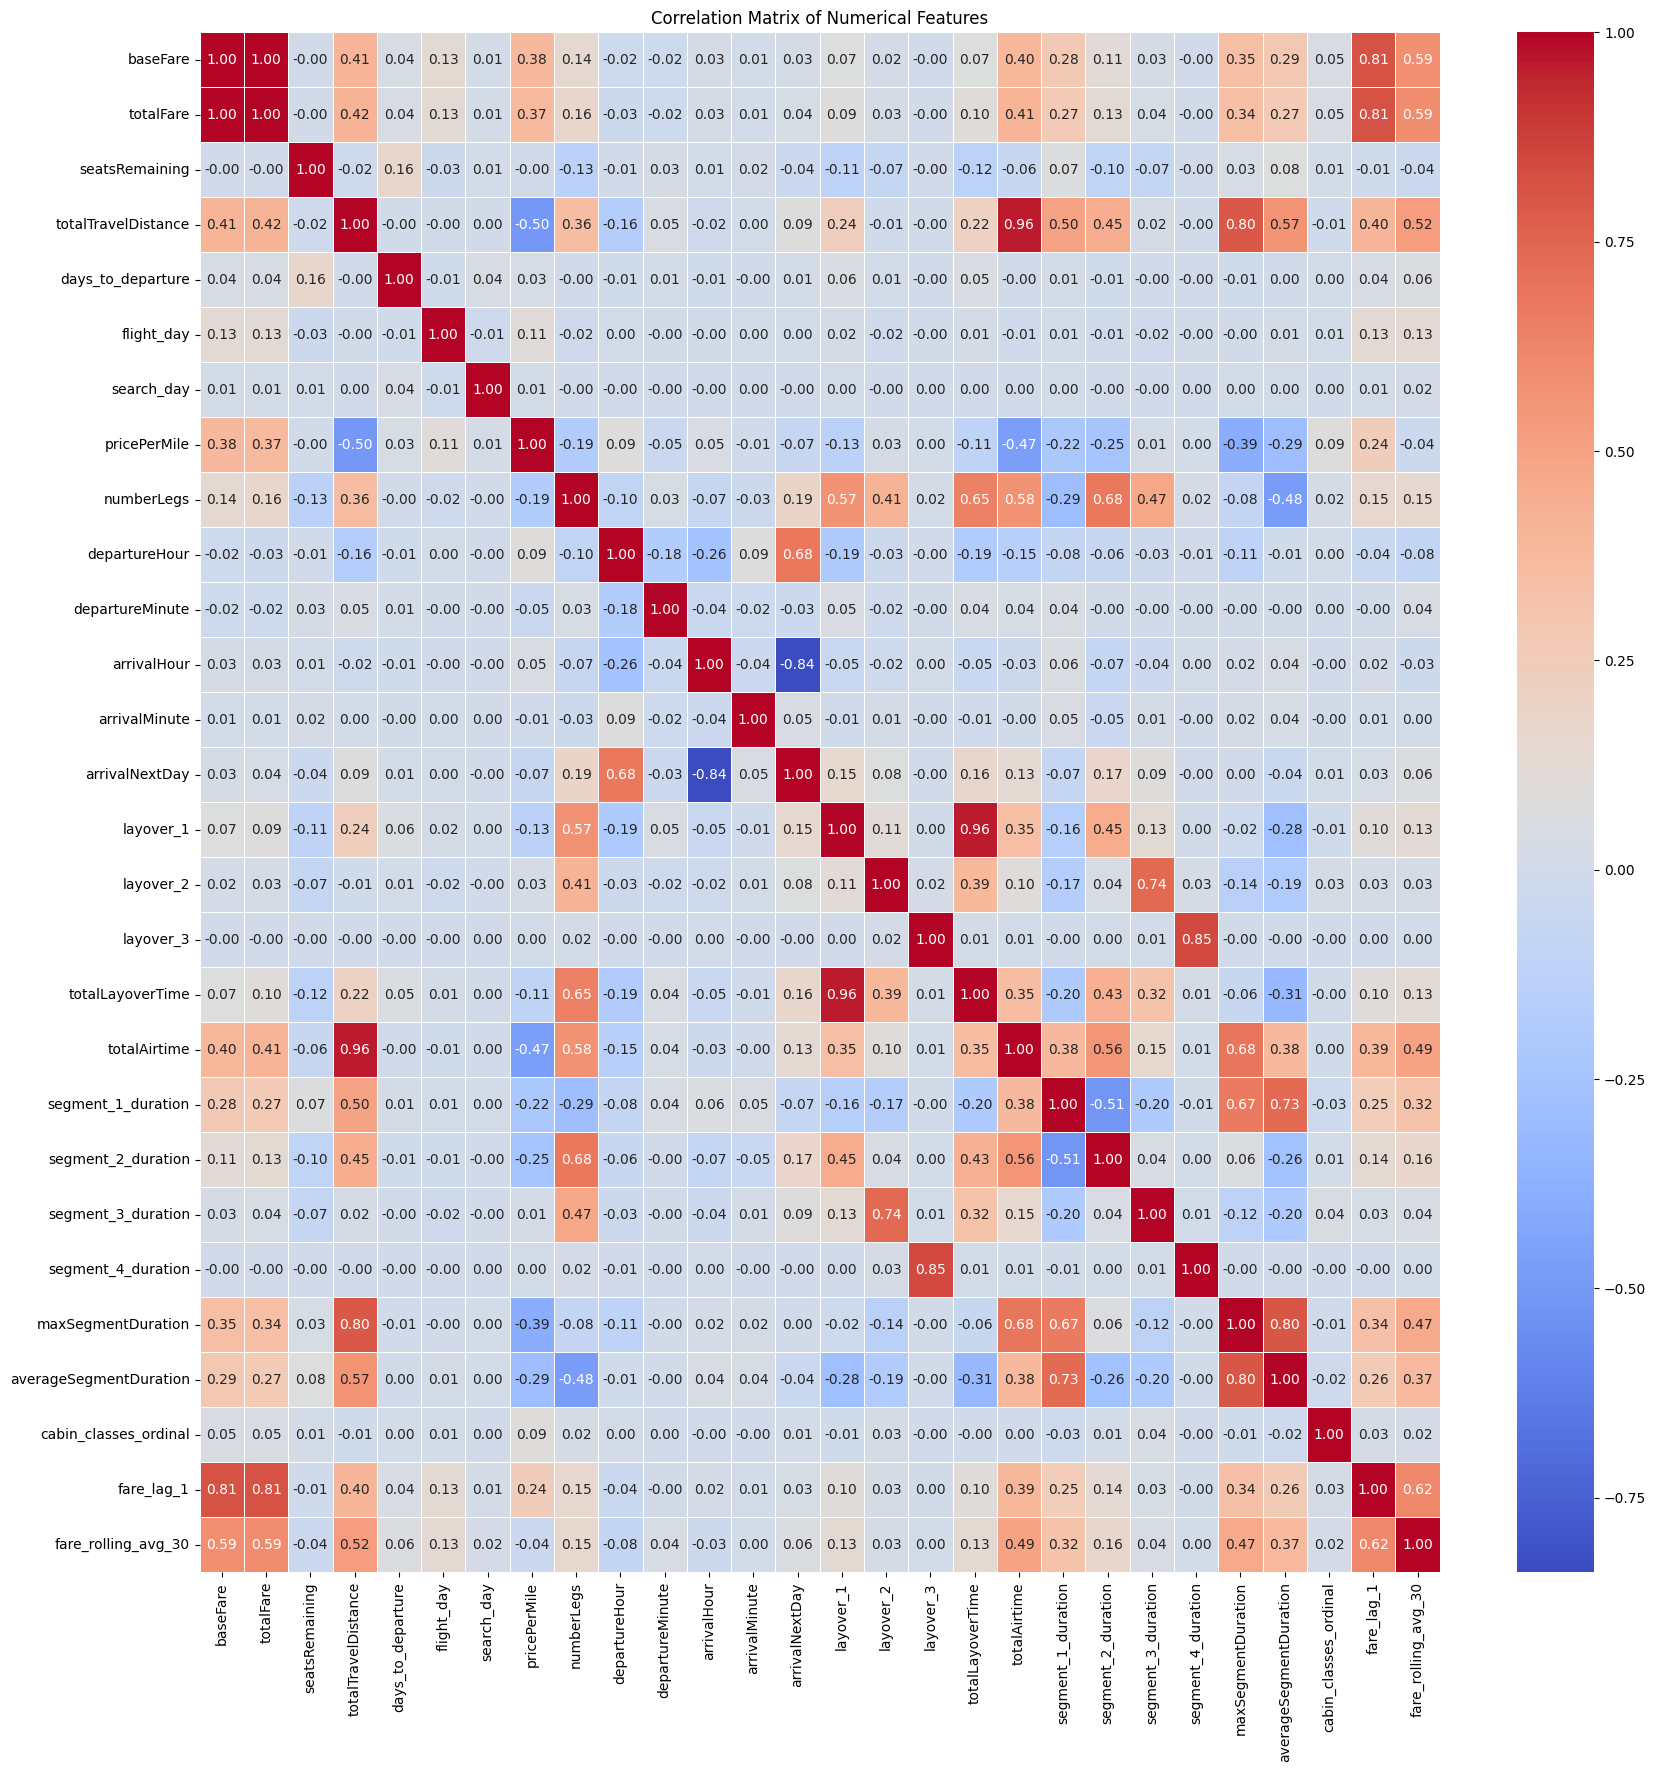

In [32]:
# List of columns to exclude (boolean or categorical columns)
exclude_columns = [
    'isBasicEconomy', 'isRefundable', 'isNonStop', 'flightMonth',
    'searchMonth', 'isHoliday'
]

# Select numerical columns and drop the excluded ones
numerical_cols = df.select_dtypes(include=['float64', 'int32', 'int64']).drop(columns=exclude_columns)

# Calculate the correlation matrix
corr_matrix = numerical_cols.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [33]:
'''
#Drop Segment columns that have already been split or were ultimately unneeded   
#Drop column startingAirport. LAX is the only starting airport 
#Drop legId, offers no useful prediction tools and isn't needed for any other use
#Drop baseFare, only need one between baseFare and totalFare (totalFare more comprehensive)
#We are interested in the departing and arriving airport code only, so the intermediate airport code can be dropped 
#Drop Departure and Arrival columns now that all necessary information has been extracted
df = df.drop(['startingAirport', 'legId', 'baseFare', 'segmentsDurationInSeconds', 
                      'segmentsDistance', 'segmentsDepartureTimeEpochSeconds', 
                      'segmentsArrivalTimeEpochSeconds', 'flightDate',
                      'dep_1', 'dep_2', 'dep_3', 'dep_4', 
                      'arr_1', 'arr_2', 'arr_3', 'arr_4', 
                      'layover_1', 'layover_2', 'layover_3', 
                      'segment_1_duration','segment_2_duration', 'segment_3_duration' ,'segment_4_duration', 
                      'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 
                      'segmentsAirlineName', 'segmentsCabinCode', 'same_cabin_type'], axis=1).reset_index(drop=True) '''

In [34]:
#Review remaining columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3873359 entries, 0 to 3873358
Data columns (total 33 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   destinationAirport         object 
 1   fareBasisCode              object 
 2   travelDuration             object 
 3   isBasicEconomy             int64  
 4   isRefundable               int64  
 5   isNonStop                  int64  
 6   totalFare                  float64
 7   seatsRemaining             int64  
 8   totalTravelDistance        float64
 9   days_to_departure          int64  
 10  flight_month               int32  
 11  flight_day                 int32  
 12  search_month               int32  
 13  search_day                 int32  
 14  is_holiday                 int64  
 15  pricePerMile               float64
 16  numberLegs                 int64  
 17  departureHour              int32  
 18  departureMinute            int32  
 19  arrivalHour                int32  
 20  ar

In [ ]:
#Check for any missing or null values after feature engineering 
missing_values = df.isnull().sum()
print(missing_values)

destinationAirport           0
fareBasisCode                0
travelDuration               0
isBasicEconomy               0
isRefundable                 0
isNonStop                    0
totalFare                    0
seatsRemaining               0
totalTravelDistance          0
days_to_departure            0
flight_month                 0
flight_day                   0
search_month                 0
search_day                   0
is_holiday                   0
pricePerMile                 0
numberLegs                   0
departureHour                0
departureMinute              0
arrivalHour                  0
arrivalMinute                0
arrivalNextDay               0
totalLayoverTime             0
totalAirtime                 0
maxSegmentDuration           0
averageSegmentDuration       0
firstLayoverAirport          0
mainAirline                  0
cabin_classes                0
cabin_classes_combination    0
cabin_classes_ordinal        0
fare_lag_1                   0
fare_rol

## Handling Outliers 

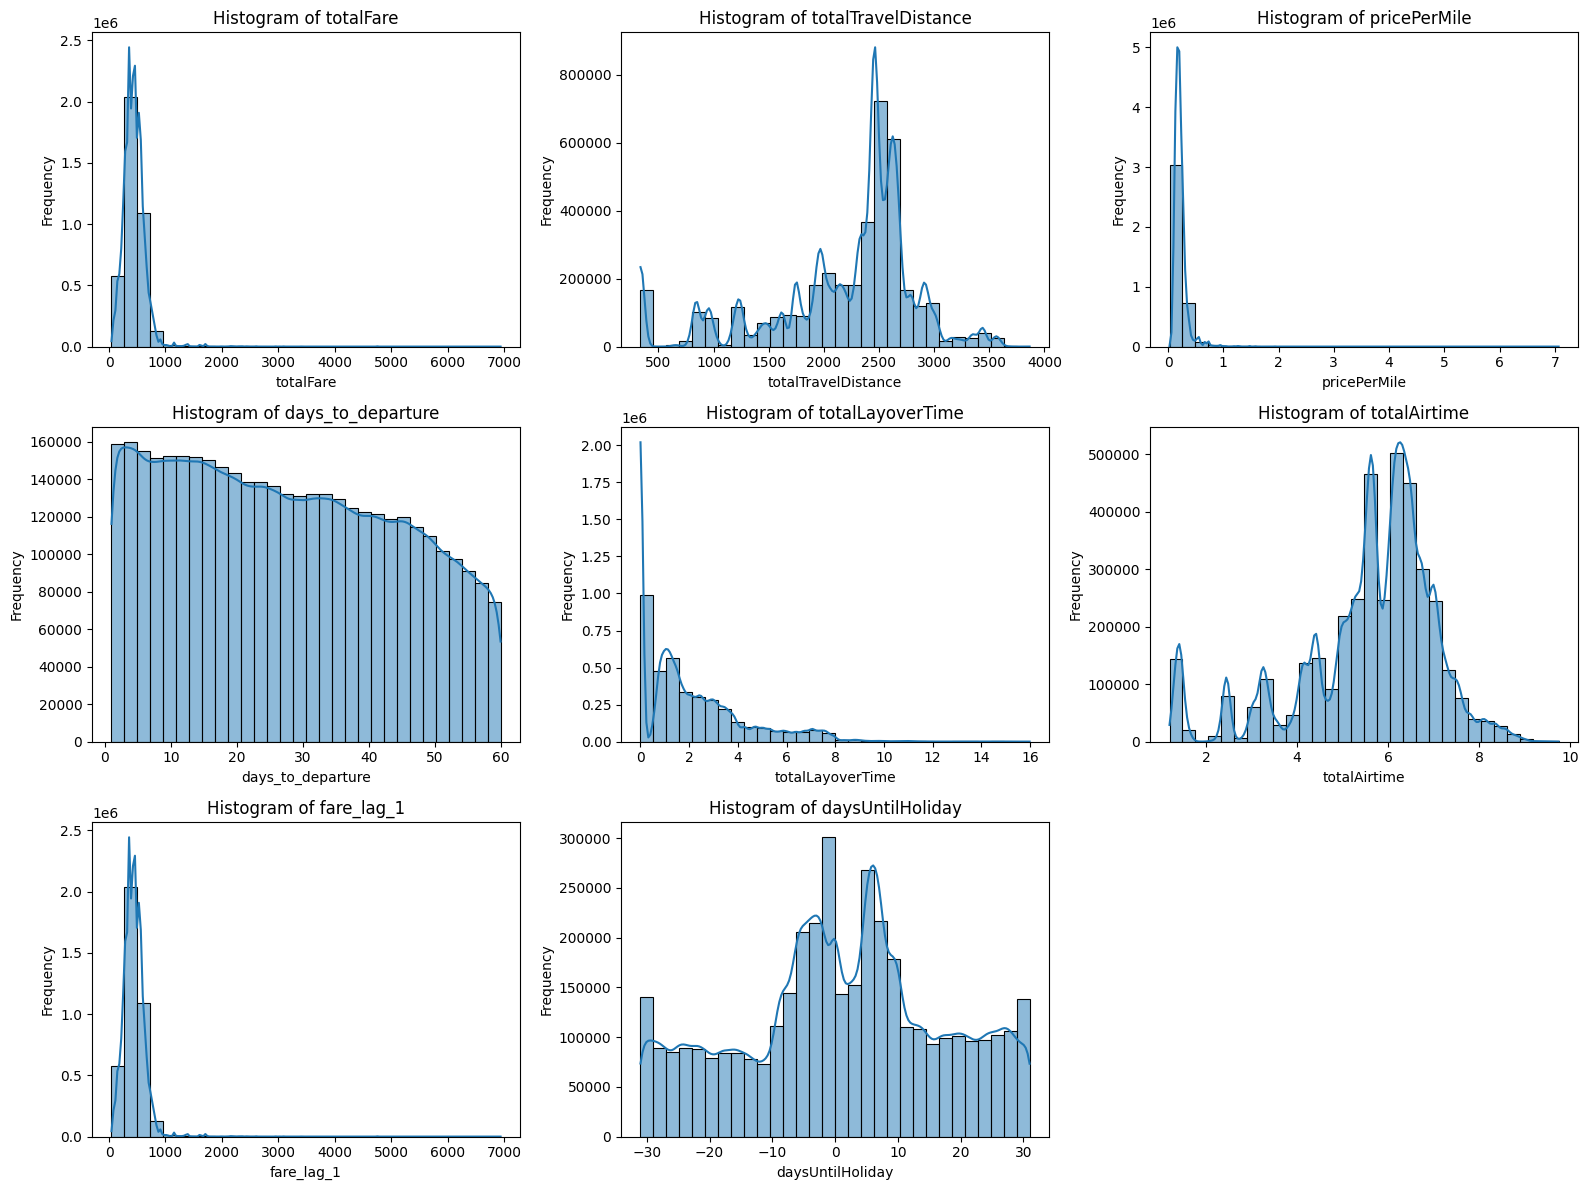

In [79]:
# List of continuous numerical features to check for outliers
outlier_columns = [
    'totalFare', 
    'totalTravelDistance', 
    'pricePerMile', 
    'daysToDeparture', 
    'totalLayoverTime', 
    'totalAirtime', 
    'fareLag_1', 
    'daysUntilHoliday'
]

# Plot histograms for each feature
plt.figure(figsize=(16, 12))
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


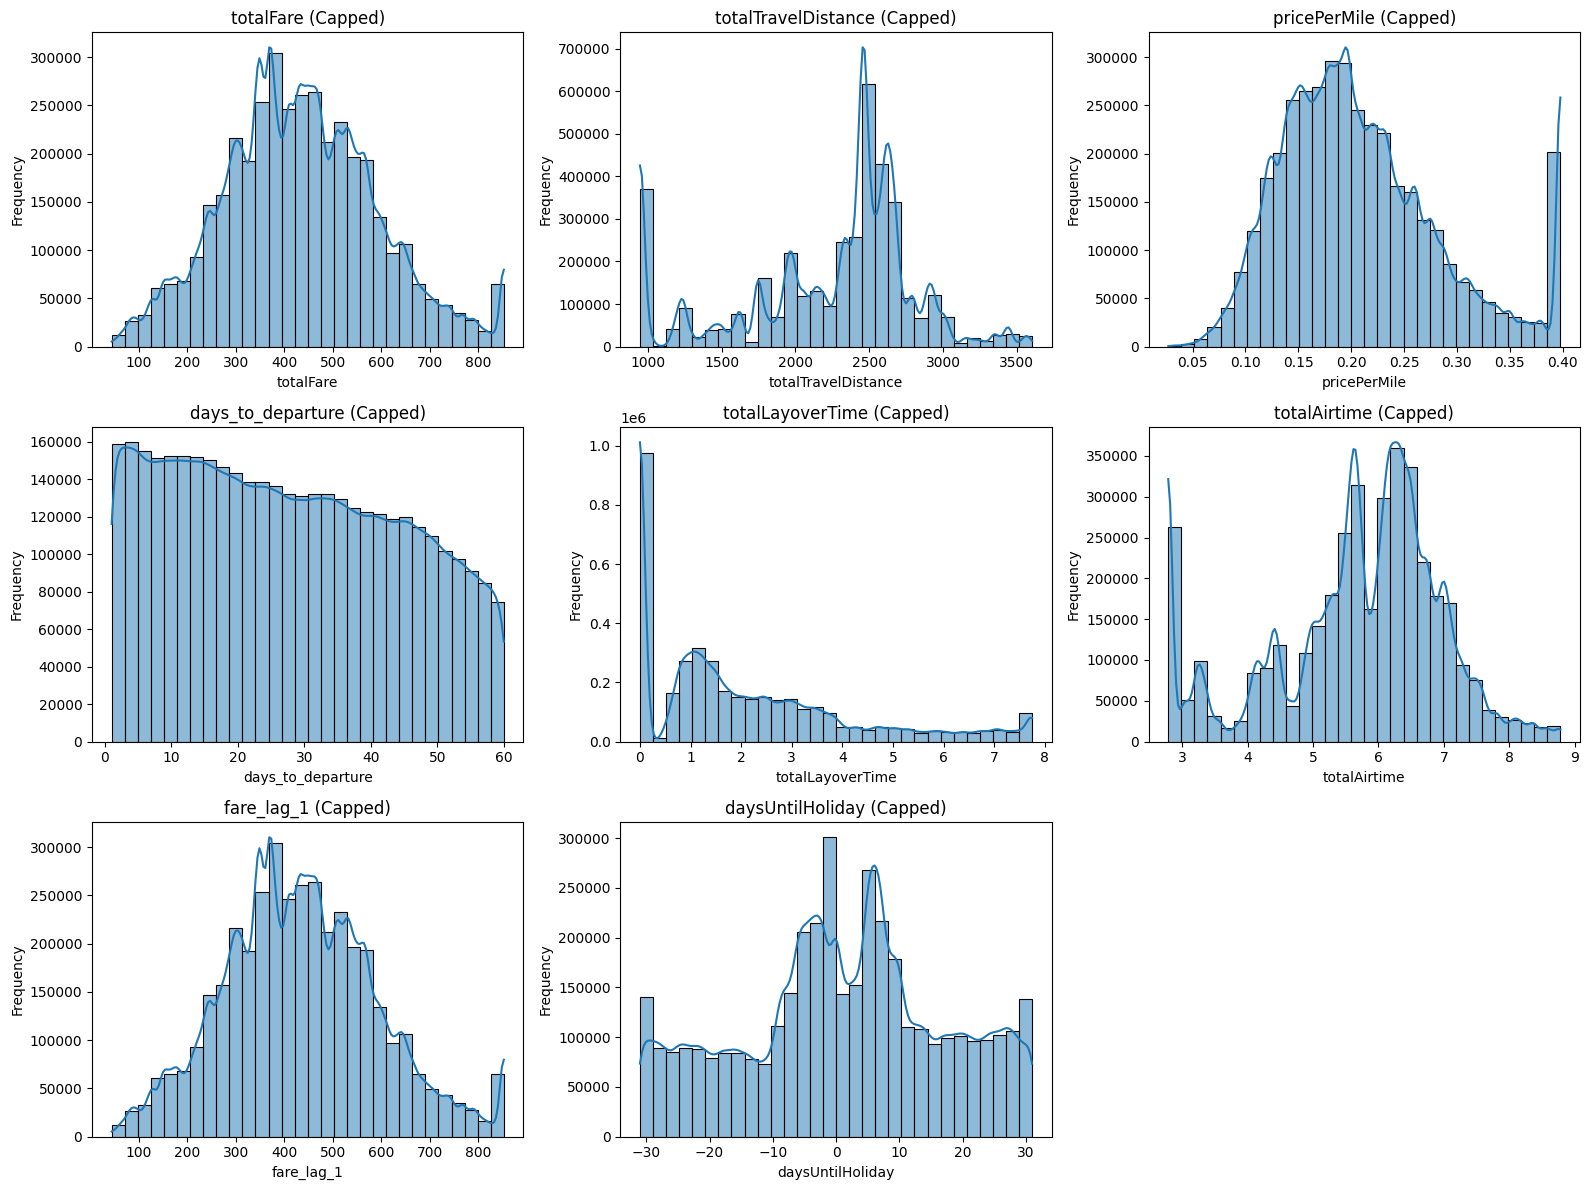

Dataset size after capping: 3873359


In [82]:
# List of continuous numerical features to apply outlier capping
outlier_columns = [
    'totalFare', 
    'totalTravelDistance', 
    'pricePerMile', 
    'daysToDeparture', 
    'totalLayoverTime', 
    'totalAirtime', 
    'fareLag_1', 
    'daysUntilHoliday'
]

# Choose a multiplier for the IQR; adjust if needed (e.g., 1.5 or 2.0)
multiplier = 1.5

# Create a copy of the original dataframe for capping outliers
df_capped = df.copy()

# Apply capping on each column using the IQR method
for col in outlier_columns:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    # Cap the values at the calculated bounds
    df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)

# Visualize the distributions after capping to review the effect
plt.figure(figsize=(16, 12))
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_capped[col].dropna(), kde=True, bins=30)
    plt.title(f'{col} (Capped)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Print a summary to check that the dataset size remains unchanged
print("Dataset size after capping:", df_capped.shape[0])


## Analyzing for Possible data augmentation or enrichement needs

In [37]:
# Check data types
print(df.dtypes)

# Ensure all categorical values are strings before checking unique counts
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col] = df[col].astype(str)  # Convert lists to strings
    print(f"{col}: {df[col].nunique()} unique values")



destinationAirport            object
fareBasisCode                 object
travelDuration                object
isBasicEconomy                 int64
isRefundable                   int64
isNonStop                      int64
totalFare                    float64
seatsRemaining                 int64
totalTravelDistance          float64
days_to_departure              int64
flight_month                   int32
flight_day                     int32
search_month                   int32
search_day                     int32
is_holiday                     int64
pricePerMile                 float64
numberLegs                     int64
departureHour                  int32
departureMinute                int32
arrivalHour                    int32
arrivalMinute                  int32
arrivalNextDay                 int64
totalLayoverTime             float64
totalAirtime                 float64
maxSegmentDuration           float64
averageSegmentDuration       float64
firstLayoverAirport           object
m

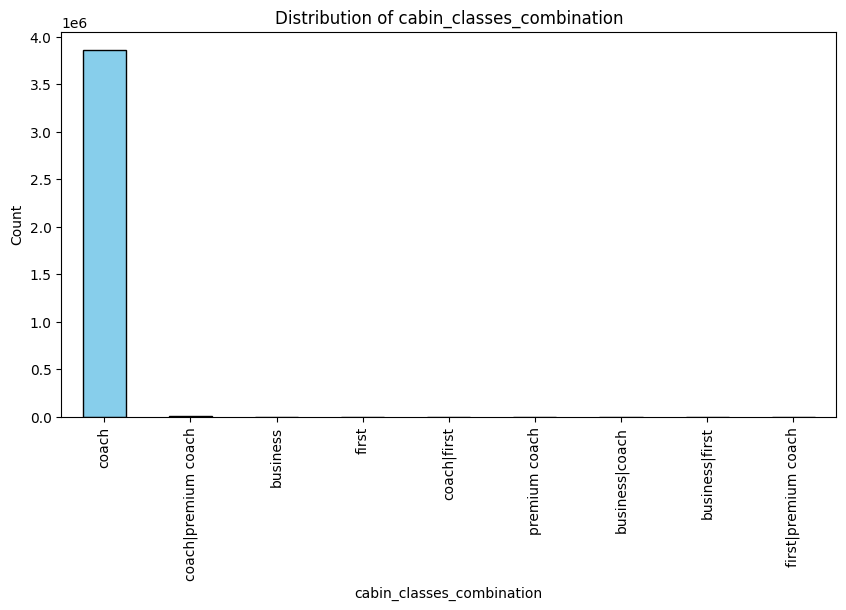

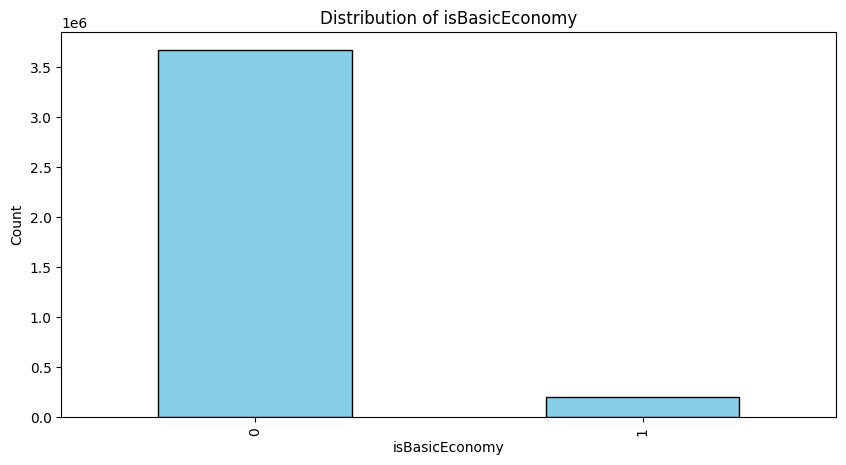

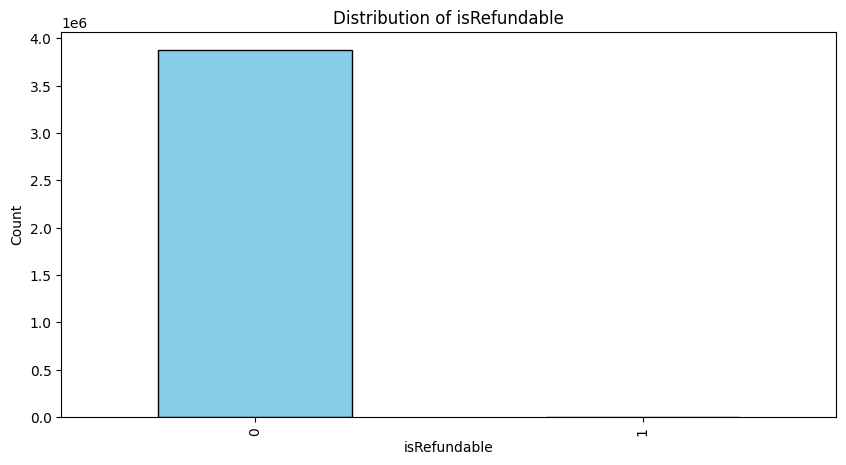

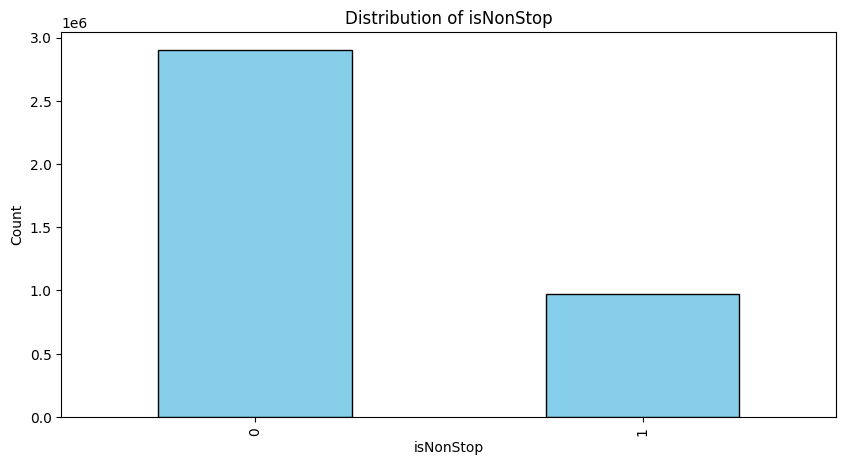

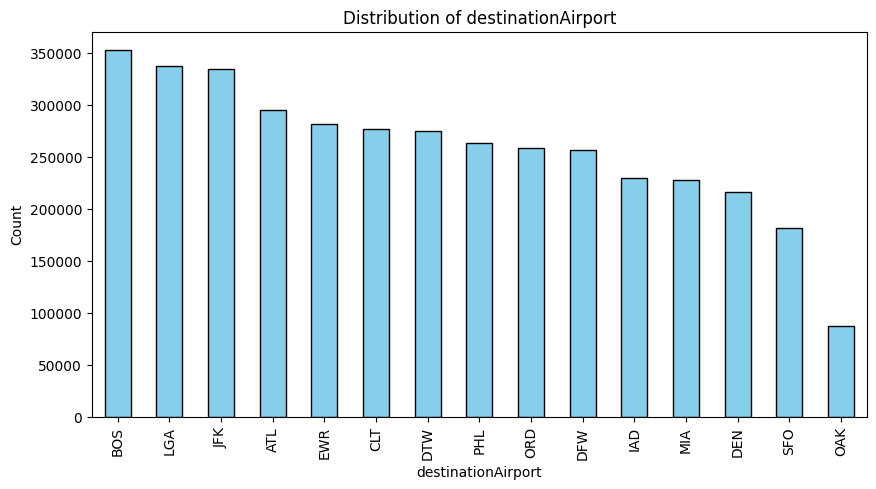

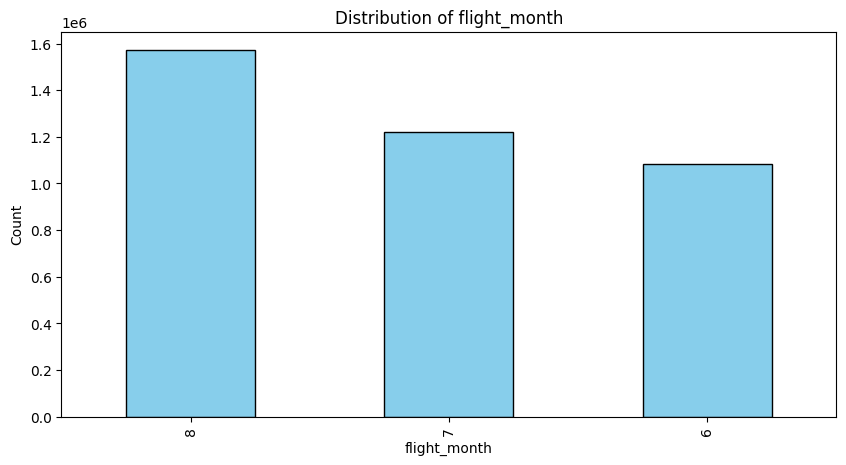

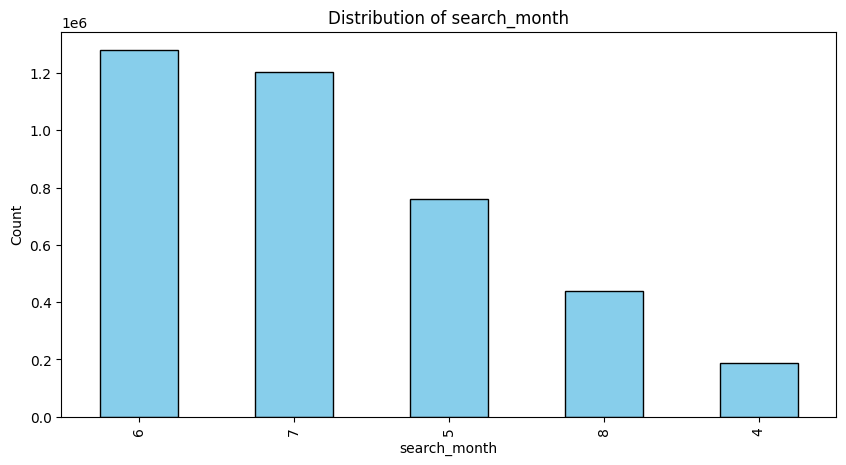

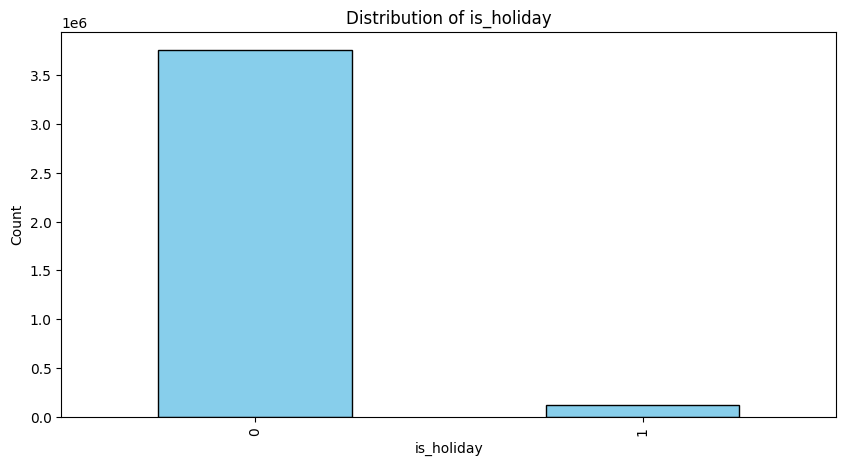

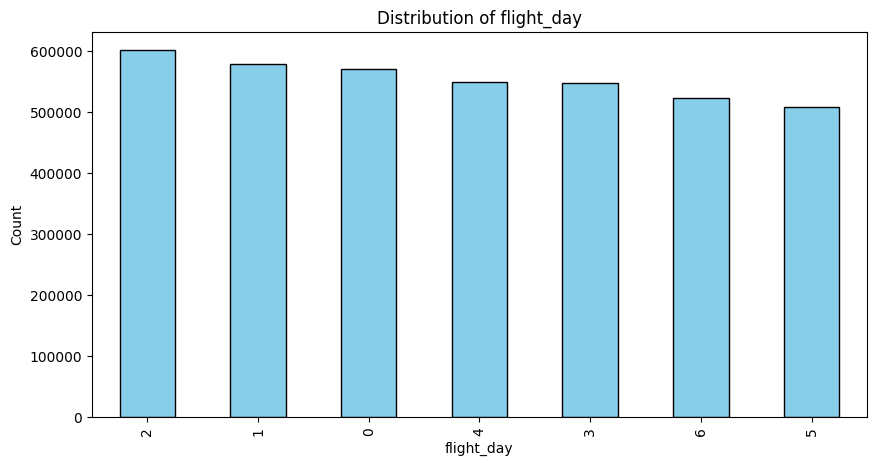

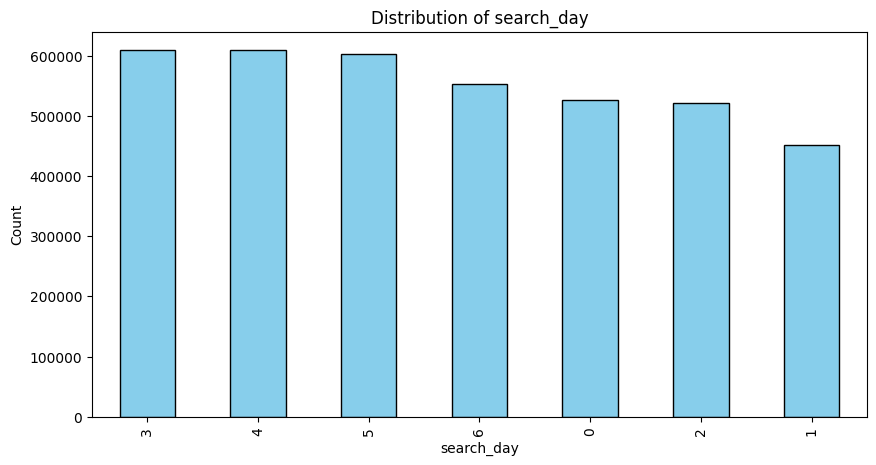

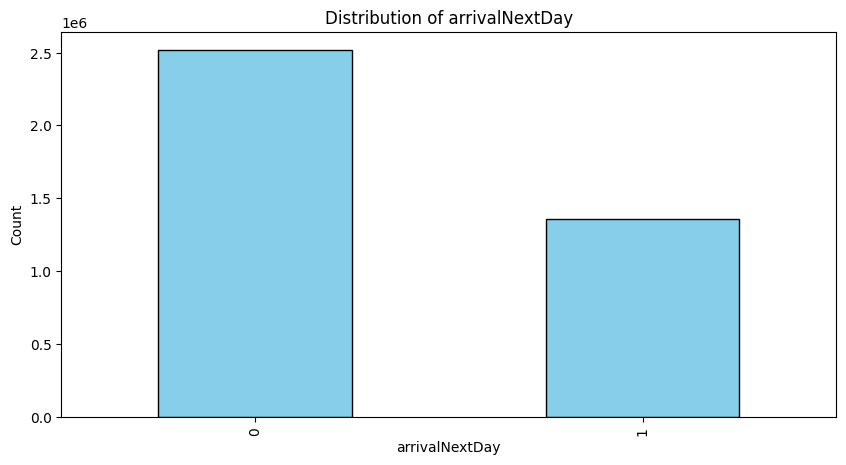

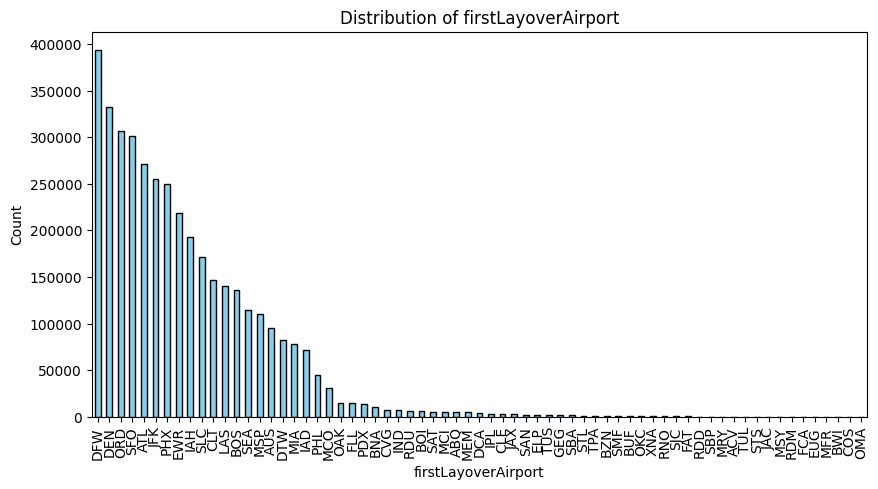

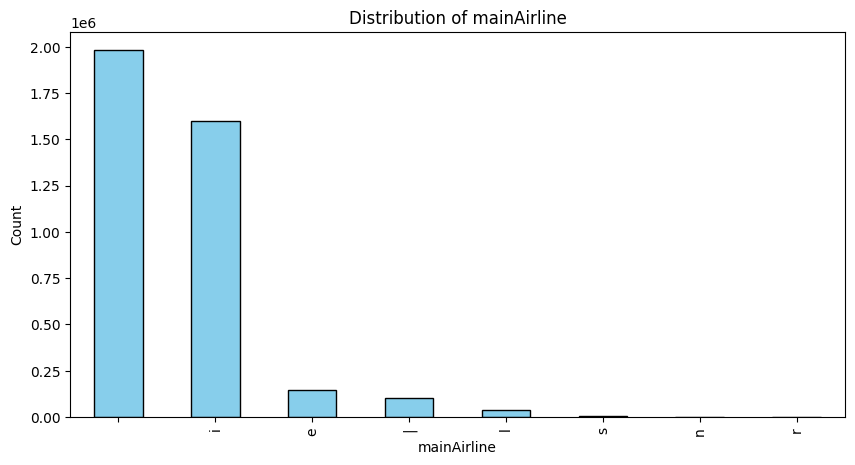

In [ ]:
# Categorical Columns
categorical_cols = ['cabinClassesCombination', 'isBasicEconomy', 'isRefundable', 
                    'isNonStop', 'destinationAirport', 'flightMonth', 'searchMonth', 
                    'isHoliday', 'flightDay', 'searchDay', 'arrivalNextDay', 'firstLayoverAirport', 'mainAirline']

# Define grid layout 
n_cols = 5
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15)) 
axes = axes.flatten()  

for i, col in enumerate(categorical_cols):
    df[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=90)  

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

